In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
from sklearn.cluster import MeanShift
# Import CMasher to register colormaps
import cmasher as cmr
import geopandas as gpd
import cftime

/home/estudiantes/anaconda/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
df=pd.read_csv("IDD.csv",header=None)
ID=df[(df[0]>="760011-99999")&(df[0]<="780160-13601")] 
ID1=ID[0].str.split(pat="-", expand=True) #Separando 
ID["ID"]=ID1[0].astype(int)

esta=pd.read_fwf("ID.txt",header=None)
p=esta[1]
filtered_df = ID[(ID["ID"]).isin(p)]
filtered_df #Encontrando los datos de las estaciones que ocupamos
lat=filtered_df[2].values
lon=filtered_df[3].values
ele=filtered_df[4].values

#Agregando la elevación al dataframe
esta["elevacion"]=ele
esta["Lat"]=lat
esta["Lon"]=lon
esta["Lugar"]=filtered_df[1].values

/tmp/ipykernel_140639/1060579645.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ID["ID"]=ID1[0].astype(int)


In [3]:
def lineplot_setup(xmin,xmax,xlab,ylab,ymin=None,ymax=None,title=None,legend=False):
    # especificar limites minimos y maximos del grafico
    plt.xlim([xmin,xmax])
    plt.ylim([ymin,ymax])
    # cuadrilla interna del grafico
    plt.grid(linestyle='--',alpha=0.66)
    plt.minorticks_on()
    # hacer las etiquetas de ambos ejes mas grandes
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel(xlab,fontsize=14)
    plt.ylabel(ylab,fontsize=14)
    plt.title(title,fontsize=15)
    if legend:
        plt.legend(fancybox=True,shadow=True,fontsize=12.5)

In [4]:
#Cargando los datos con los que se harán los clusters
da_list=[]
for i,ii in enumerate(esta[1]):
    datos=xr.open_dataset(f"/home/andreagvc/data/ERA/ERA/Datos_HAD/{ii}99999_estadisticos.nc")
    datos=datos.assign_coords(estacion=ii)
    datos=datos.expand_dims('estacion')
    da_list.append(datos)
seas=xr.concat(da_list,dim='estacion')

In [5]:
def ciclo_anual(dato,mean):
    dat=dato.groupby(dato.time.dt.month).mean()
    anual=dat.mean(mean)
    return anual

In [6]:
cluster=pd.read_csv("clusterinf_Had.csv")

In [7]:
cluster0=cluster.loc[cluster.cluster==0]
cluster1=cluster.loc[cluster.cluster==1]

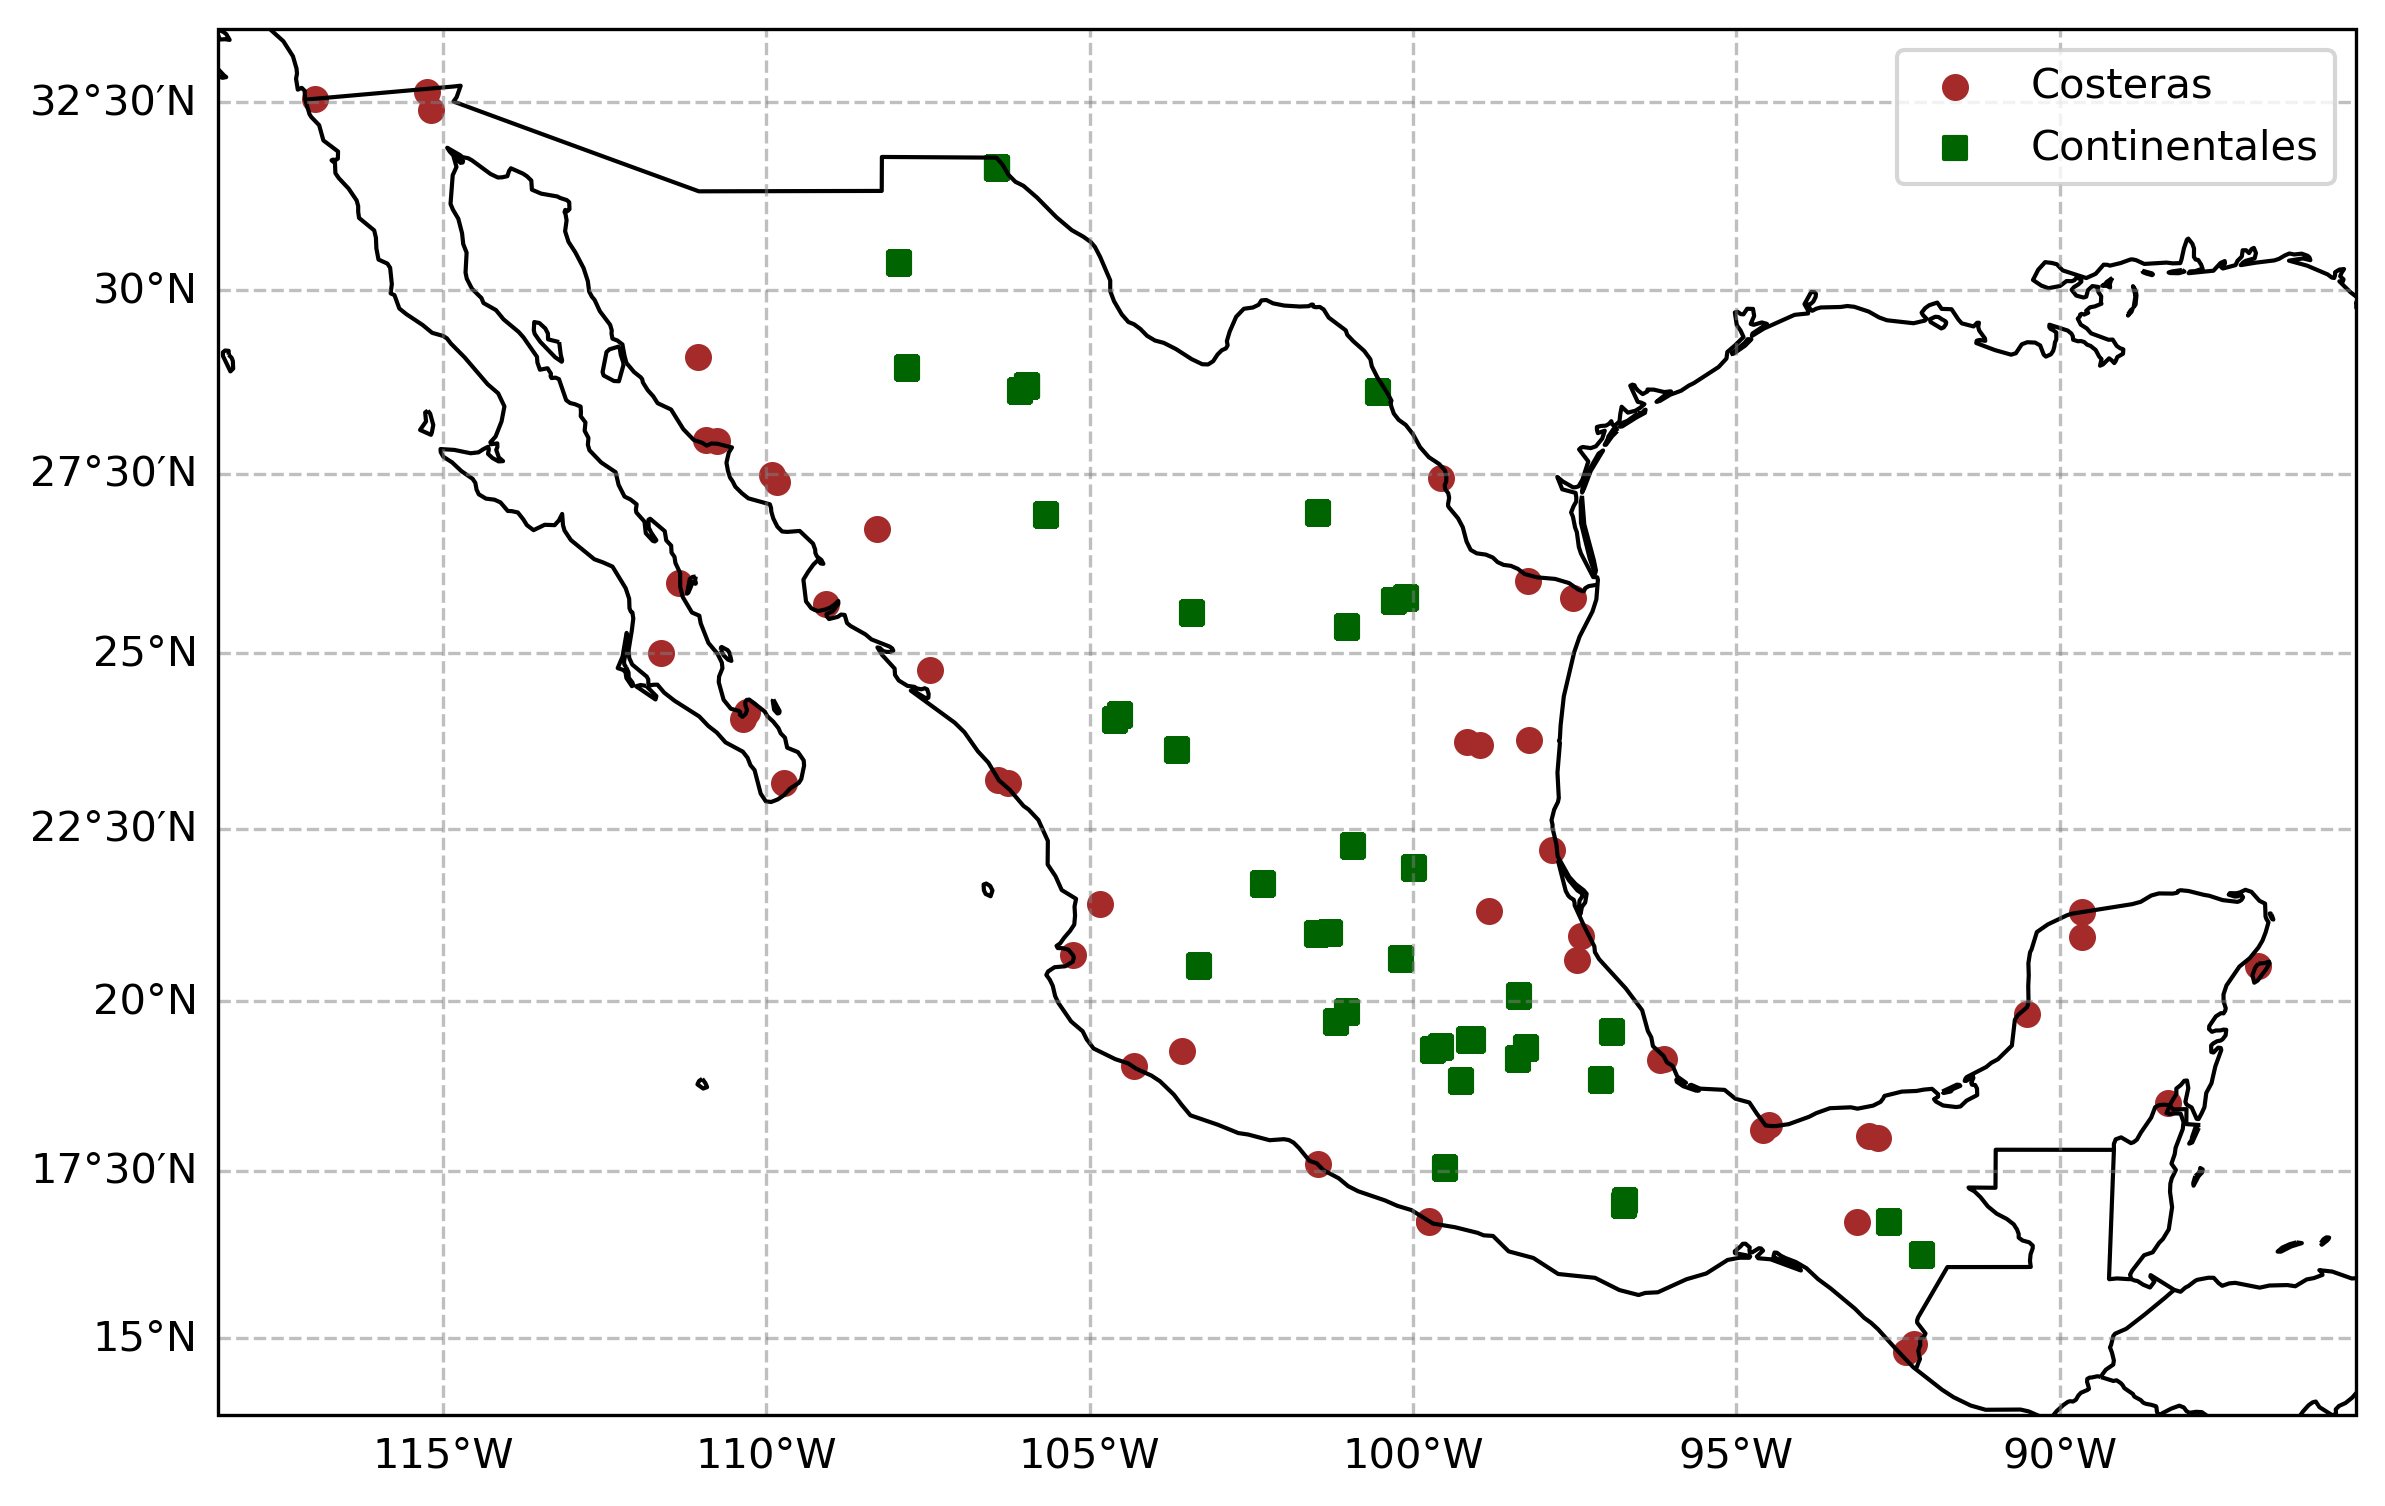

In [8]:
#Mostrando la clasificación
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.Mercator()},dpi=300)
# set_extent([lonmin,lonmax,latmin,latmax])
#ax.set_extent([-120, -90, 14, 33], crs=ccrs.PlateCarree()) #siempre tiene que llevar esto para un recorte
#ax.set_global
# fusion
ax.coastlines()

ax.add_feature(cfeature.BORDERS)
gl=ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,color='gray', alpha=0.5, linestyle='--')
ax.xlabels_top = False# It should turn off the upper x ticks
gl.top_labels = gl.right_labels = False
#El cluster0 es lo más lejano a la costa,mientras que el cluster 1 es lo más cercano a la costa
sc=ax.scatter(cluster0["Lon"].astype(float), cluster0["lat"].astype(float),color='brown', s=30,label='Costeras', transform=ccrs.PlateCarree())
#for city, lat, lon in zip(estacion0.astype(str), cluster0["lat"].astype(float), cluster0["Lon"].astype(float)):
  #  ax.text(lon, lat, city, fontsize=12, ha="right",color='blue')
ax.scatter(cluster1["Lon"].astype(float), cluster1["lat"].astype(float),c='darkgreen', marker='s', s=30,label='Continentales', transform=ccrs.PlateCarree())
#ax.scatter(cluster2["Lon"].astype(float), cluster2["lat"].astype(float),color='pink', marker='o', label='Cluster1', transform=ccrs.PlateCarree())
#ax.plot(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], label='Centros de Clusters',)
#ax.scatter(x,y)
#cbar=plt.colorbar(cs,orientation='vertical',fraction=0.1,extend="both",shrink=0.8,label='TW [$^{\circ}$C]')
#plt.title("Clusters creados con el método Kmeans")
plt.legend()
plt.savefig("Metodo_cluster.svg",dpi=300,bbox_inches="tight")
plt.show()

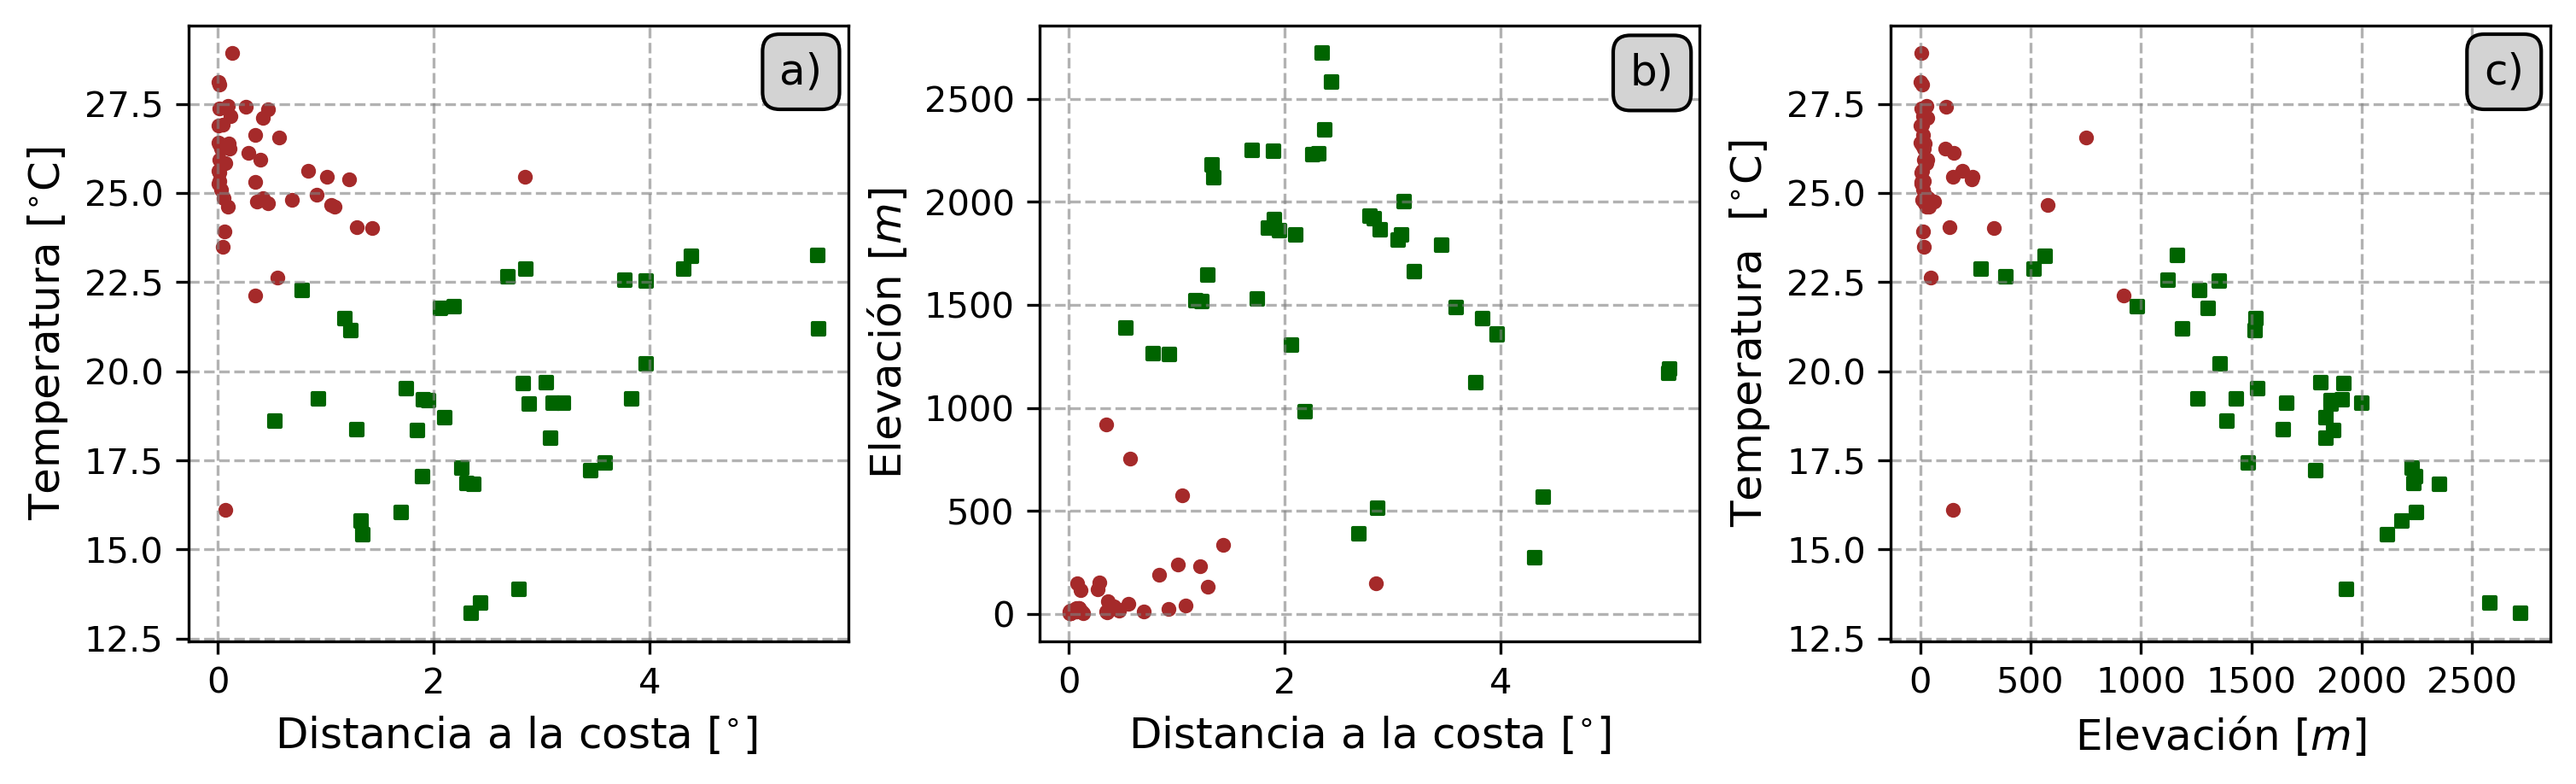

In [9]:
#Verificando la relación entre las variables para ver qué define el tipo de cluster
fig = plt.figure(figsize=(10,3),dpi=300)

plt.subplot(1,3,1)
plt.scatter(cluster0["distancia_costa"],cluster0["temperatura"],color='brown',label="cluster0",s=10)
plt.scatter(cluster1["distancia_costa"],cluster1["temperatura"],color='darkgreen', marker='s',label="cluster1",s=10)
plt.xlabel("Distancia a la costa $[^{\circ}$] ",fontsize=12)
plt.text(5.4, 28.4, "a)", fontsize=12, color="black", ha="center", va="center", bbox=dict(facecolor="lightgray", edgecolor="black", boxstyle="round",pad=0.4))
# Estilizar
plt.ylabel("Temperatura [$^{\circ}$C]",fontsize=12)
plt.xticks(size=10)
plt.yticks(size=10)
#plt.legend()
plt.grid(linestyle="--", color="grey",alpha=0.6)
#plt.title("distancia_costa vs temperatura")

plt.subplot(1,3,2)
plt.scatter(cluster0["distancia_costa"],cluster0["elevacion"],color='brown',s=10,label="cluster0")
plt.scatter(cluster1["distancia_costa"],cluster1["elevacion"],color='darkgreen', marker='s',label="cluster1",s=10)
plt.xlabel("Distancia a la costa $[^{\circ}$]",fontsize=12)
plt.ylabel("Elevación $[m]$",fontsize=12)
plt.xticks(size=10)
plt.yticks(size=10)
#plt.legend()
plt.grid(linestyle="--", color="grey",alpha=0.6)
plt.text(5.4, 2625, "b)", fontsize=12, color="black", ha="center", va="center", bbox=dict(facecolor="lightgray", edgecolor="black", boxstyle="round",pad=0.4))

plt.subplot(1,3,3)
plt.scatter(cluster0["elevacion"],cluster0["temperatura"],color='brown',s=10,label="cluster0 (cercano a la costa)")
plt.scatter(cluster1["elevacion"],cluster1["temperatura"],color='darkgreen', marker='s',label="cluster1 (lejano a la costa)",s=10)
plt.xlabel("Elevación $[m]$",fontsize=12)
plt.text(2645, 28.4, "c)", fontsize=12, color="black", ha="center", va="center", bbox=dict(facecolor="lightgray", edgecolor="black", boxstyle="round",pad=0.4))
plt.ylabel("Temperatura  $[^{\circ}$C]", fontsize=12)
plt.xticks(size=10)
plt.yticks(size=10)
#plt.legend(bbox_to_anchor=(1.05, 1.0),loc='upper left',fontsize=8)
plt.grid(linestyle="--", color="grey",alpha=0.6)
#plt.title("elevación vs temepratura")
plt.tight_layout(pad=0.5)
plt.savefig("Relacion_var.svg",dpi=300,bbox_inches="tight")
plt.show()

In [10]:
#Seleccionamos el ID para el cluster 0
Id=cluster0["ID"]
#Seleccionamos ID para el cluster 1
Id1=cluster1["ID"]

#Seleccionamos dichos ID dentro de todos nuestros datos
Datos=seas.where(seas.estacion.isin(Id),drop=True) #Cluster0
Datos1=seas.where(seas.estacion.isin(Id1),drop=True) #Cluster1


In [11]:
len(Id)

49

In [12]:
Datos

<xarray.Dataset> Size: 66MB
Dimensions:   (estacion: 49, time: 18627)
Coordinates:
  * time      (time) datetime64[ns] 149kB 1973-01-01 1973-01-02 ... 2023-12-31
  * estacion  (estacion) int64 392B 760013 760053 760400 ... 769030 769043
Data variables:
    Twmin     (estacion, time) float64 7MB nan nan nan nan ... 295.1 296.1 296.1
    Twmax     (estacion, time) float64 7MB nan nan nan nan ... 299.6 299.2 298.9
    Twmean    (estacion, time) float64 7MB nan nan nan nan ... 297.5 297.9 297.3
    Tmin      (estacion, time) float64 7MB nan nan nan nan ... 22.0 23.0 23.0
    Tmax      (estacion, time) float64 7MB nan nan nan nan ... 32.0 33.0 33.0
    Tmean     (estacion, time) float64 7MB nan nan nan nan ... 26.86 28.0 27.0
    SHmin     (estacion, time) float64 7MB nan nan nan ... 0.01735 0.01732
    SHmax     (estacion, time) float64 7MB nan nan nan ... 0.01849 0.01848
    SHmean    (estacion, time) float64 7MB nan nan nan ... 0.01809 0.01752
Attributes:
    description:  Estadísticos diarios:Twmax,Twmean,Tmax,Tmean,SHmax,SHmean

/home/estudiantes/anaconda/lib/python3.11/site-packages/xarray/groupers.py:490: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(
/home/estudiantes/anaconda/lib/python3.11/site-packages/xarray/groupers.py:490: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(
/home/estudiantes/anaconda/lib/python3.11/site-packages/xarray/groupers.py:490: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(
/home/estudiantes/anaconda/lib/python3.11/site-packages/xarray/groupers.py:490: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(


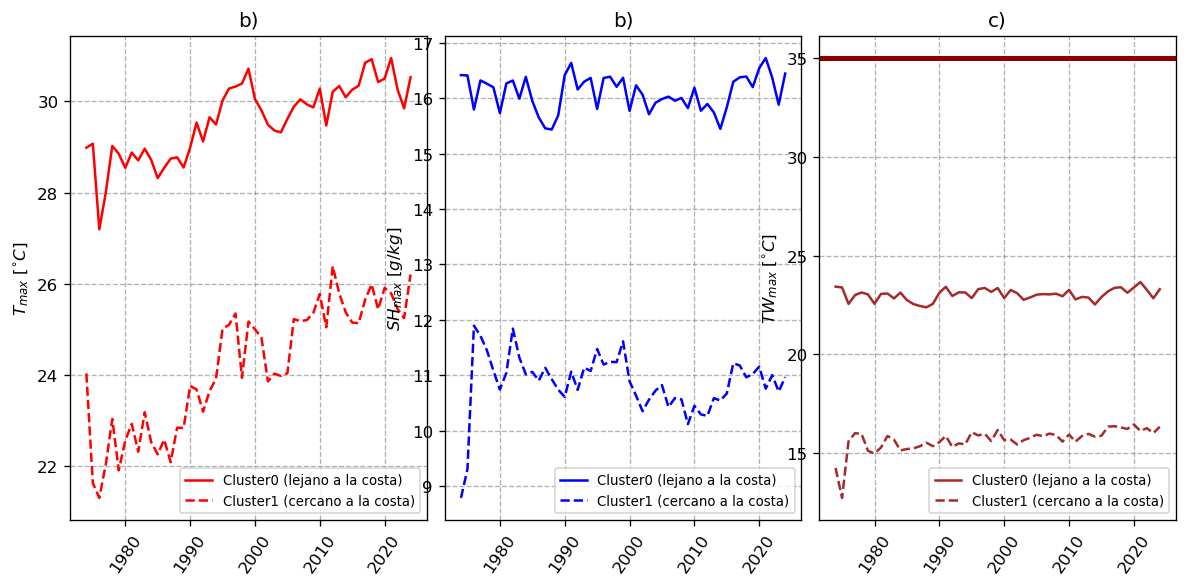

In [13]:
#Serie de tiempo para el cluster 0
#Primero obtenemos un valor por mes
Month=Datos.resample(time="M").mean()
#Luego obtenemos un valor por año
Year=Month.resample(time="Y").mean()
#Serie de tiempo
serie=Year.mean("estacion")

#Serie de tiempo para el cluster 1
#Primero obtenemos un valor por mes
Month1=Datos1.resample(time="M").mean()
#Luego obtenemos un valor por año
Year1=Month1.resample(time="Y").mean()
#Serie de tiempo
serie1=Year1.mean("estacion")


#Graficando la serie de tiempo del cluster 0 y cluster 1
#Para las gráficas, dabo que por cluster queremos información más específica, sólo ocuparemos los valores máximos de cada variable
datos=["a)","b)","c)"]
variables=["Tmax","SHmax","Twmax"]
labels=["$T_{max}$ $[^{\circ}C]$","$SH_{max}$ $[g/kg]$","$TW_{max}$ $[^{\circ}C]$"]
colors=["red","blue","#A52A2A"]

plt.figure(figsize=(10,5),dpi=120)
for ii,jj in enumerate(variables):
    if jj=="Twmax":
        plt.subplot(1, 3, 3)
        plt.plot(serie[jj].time,serie[jj]-273.15,color=colors[ii],label="Cluster0 (lejano a la costa)")
        plt.plot(serie1[jj].time,serie1[jj]-273.15,color=colors[ii],label="Cluster1 (cercano a la costa)",linestyle="--")
        plt.axhline(y=35,c='darkred',linewidth=3)
        plt.xticks(rotation=55)
        plt.ylabel(labels[ii])
        plt.title("c)")
        plt.grid(linestyle="--", color="grey",alpha=0.6)
        plt.legend(fontsize=8)
        

    elif jj=="SHmax":
        plt.subplot(1, 3, 2)
        plt.plot(serie[jj].time,serie[jj]*1000,color=colors[ii],label="Cluster0 (lejano a la costa)")
        plt.plot(serie1[jj].time,serie1[jj]*1000,color=colors[ii],label="Cluster1 (cercano a la costa)",linestyle="--")
        plt.xticks(rotation=55)
        plt.ylabel(labels[ii])
        plt.title("b)")
        plt.grid(linestyle="--", color="grey",alpha=0.6)
        plt.legend(fontsize=8)
       
    
      
    else:
        plt.subplot(1, 3, 1)
        plt.plot(serie[jj].time,serie[jj],color=colors[ii],label="Cluster0 (lejano a la costa)")
        plt.plot(serie1[jj].time,serie1[jj],color=colors[ii],label="Cluster1 (cercano a la costa)",linestyle="--")
        plt.xticks(rotation=55)
        plt.ylabel(labels[ii])
        plt.title("b)")
        plt.grid(linestyle="--", color="grey",alpha=0.6)
        plt.legend(fontsize=8)
        plt.tight_layout()
#plt.figure(figsize=(10,2),dpi=120)
#plt.subplot(1,3,1)
#plt.plot(serie.time,(serie1.Tmax-serie.Tmax))
#plt.grid(linestyle="--", color="grey",alpha=0.6)
#plt.ylabel()
#plt.subplot(1,3,2)
#plt.plot(serie.time,serie1.SHmax*1000-serie.SHmax*1000)
#plt.grid(linestyle="--", color="grey",alpha=0.6)
#plt.subplot(1,3,3)
#plt.plot(serie.time,(serie1.Twmax-273.15)-(serie.Twmax-273.15))
#plt.grid(linestyle="--", color="grey",alpha=0.6)
plt.savefig("serie_por_cluster.svg")

/tmp/ipykernel_140639/2827487578.py:45: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_140639/2827487578.py:28: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


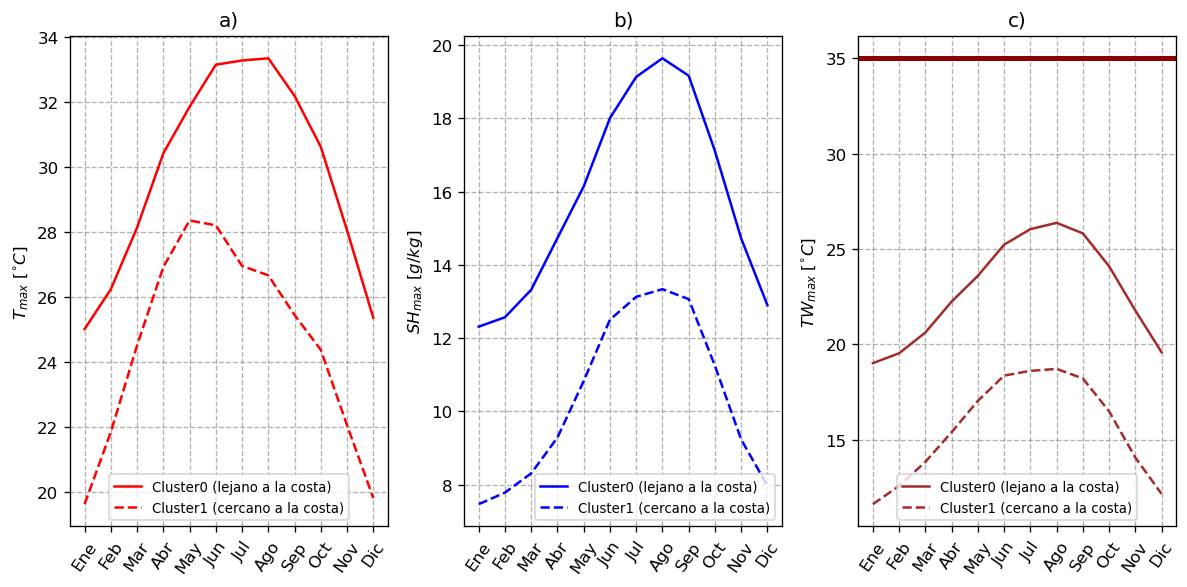

In [14]:
#Ciclo anual por cluster y para cada variable
#Retomando el promedio para cada mes y año
datos=["a)","b)","c)"]
variables=["Tmax","SHmax","Twmax"]
labels=["$T_{max}$ $[^{\circ}C]$","$SH_{max}$ $[g/kg]$","$TW_{max}$ $[^{\circ}C]$"]
colors=["red","blue","#A52A2A"]
meses=['Ene','Feb','Mar','Abr','May','Jun','Jul', 'Ago','Sep','Oct','Nov','Dic']

n=1
plt.figure(figsize=(10,5),dpi=120)
for ii,jj in enumerate(variables):
    plt.subplot(1, 3, n)
    if jj=="Twmax":
        dat=Month[jj].groupby("time.month").mean()
        anual=dat.mean("estacion")

        dat1=Month1[jj].groupby("time.month").mean()
        anual1=dat1.mean("estacion")
    
        plt.plot(meses,anual-273.15,color=colors[ii],label="Cluster0 (lejano a la costa)")
        plt.plot(meses,anual1-273.15,color=colors[ii],label="Cluster1 (cercano a la costa)",linestyle="--")
        plt.axhline(y=35,c='darkred',linewidth=3)
        plt.xticks(rotation=55)
        plt.ylabel(labels[ii])
        plt.title("c)")
        plt.grid(linestyle="--", color="grey",alpha=0.6)
        plt.legend(fontsize=8,loc="lower center")
        plt.tight_layout()
    
        n=n+1
    elif jj=="SHmax":
        dat=Month[jj].groupby("time.month").mean()
        anual=dat.mean("estacion")

        dat1=Month1[jj].groupby("time.month").mean()
        anual1=dat1.mean("estacion")
        
        plt.plot(meses,anual*1000,color=colors[ii],label="Cluster0 (lejano a la costa)")
        plt.plot(meses,anual1*1000,color=colors[ii],label="Cluster1 (cercano a la costa)",linestyle="--")
        plt.xticks(rotation=55)
        plt.ylabel(labels[ii])
        plt.title("b)")
        plt.grid(linestyle="--", color="grey",alpha=0.6)
        plt.legend(fontsize=8)
        plt.tight_layout()
        n=n+1
    else:

        dat=Month[jj].groupby("time.month").mean()
        anual=dat.mean("estacion")

        dat1=Month1[jj].groupby("time.month").mean()
        anual1=dat1.mean("estacion")
        
        plt.plot(meses,anual,color=colors[ii],label="Cluster0 (lejano a la costa)")
        plt.plot(meses,anual1,color=colors[ii],label="Cluster1 (cercano a la costa)",linestyle="--")
        plt.xticks(rotation=55)
        plt.ylabel(labels[ii])
        plt.title("a)")
        plt.grid(linestyle="--", color="grey",alpha=0.6)
        plt.legend(fontsize=8)
        plt.tight_layout()
        
        n=n+1
plt.savefig("ciclo_anual_por_cluster.svg")

In [15]:
dat=Month.groupby("time.season").mean()
estacio=dat.mean("estacion")

dat1=Month1.groupby("time.season").mean()
estacio1=dat1.mean("estacion")

/tmp/ipykernel_140639/3270310180.py:48: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_140639/3270310180.py:30: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


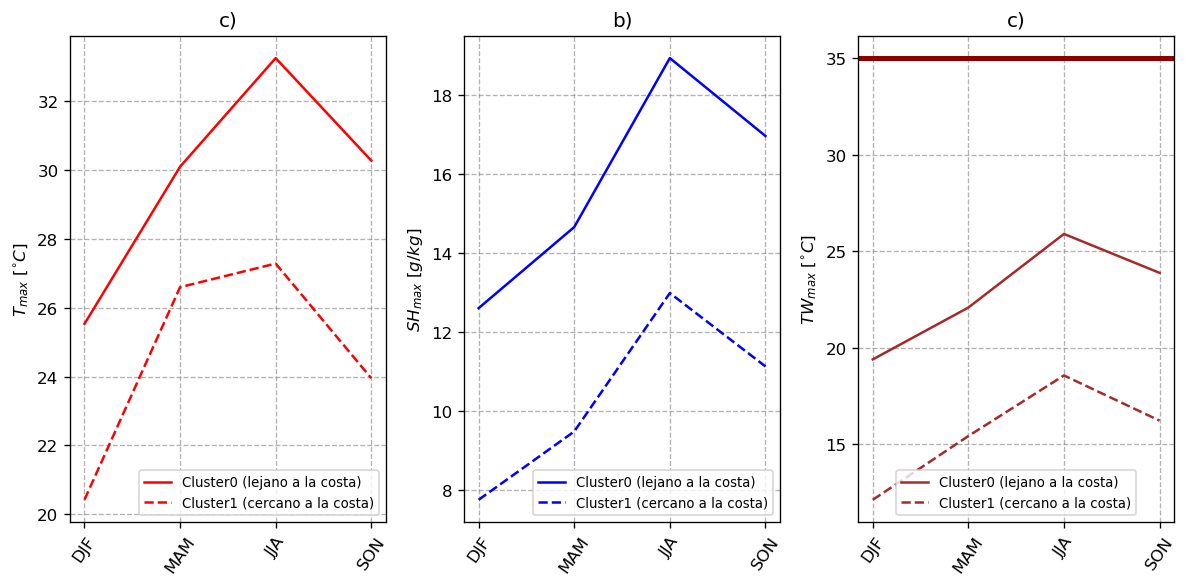

In [16]:
#Ciclo estacional por cluster
#Ciclo anual por cluster y para cada variable
#Retomando el promedio para cada mes y año
datos=["a)","b)","c)"]
variables=["Tmax","SHmax","Twmax"]
labels=["$T_{max}$ $[^{\circ}C]$","$SH_{max}$ $[g/kg]$","$TW_{max}$ $[^{\circ}C]$"]
colors=["red","blue","#A52A2A"]

seaso=["DJF","MAM","JJA","SON"]
n=1
plt.figure(figsize=(10,5),dpi=120)
for ii,jj in enumerate(variables):
    plt.subplot(1, 3, n)
    if jj=="Twmax":
        es=estacio[jj]-273.15

        es1=estacio1[jj]-273.15
        
        season=[es[0],es[2],es[1],es[3]]
        season1=[es1[0],es1[2],es1[1],es1[3]]
    
        plt.plot(seaso,season,color=colors[ii],label="Cluster0 (lejano a la costa)")
        plt.plot(seaso,season1,color=colors[ii],label="Cluster1 (cercano a la costa)",linestyle="--")
        plt.axhline(y=35,c='darkred',linewidth=3)
        plt.xticks(rotation=55)
        plt.ylabel(labels[ii])
        plt.title("c)")
        plt.grid(linestyle="--", color="grey",alpha=0.6)
        plt.legend(fontsize=8,loc="lower center")
        plt.tight_layout()
    
        n=n+1
    elif jj=="SHmax":
        es=estacio[jj]*1000

        es1=estacio1[jj]*1000
        
        season=[es[0],es[2],es[1],es[3]]
        season1=[es1[0],es1[2],es1[1],es1[3]]
    
        plt.plot(seaso,season,color=colors[ii],label="Cluster0 (lejano a la costa)")
        plt.plot(seaso,season1,color=colors[ii],label="Cluster1 (cercano a la costa)",linestyle="--")
        plt.xticks(rotation=55)
        plt.ylabel(labels[ii])
        plt.title("b)")
        plt.grid(linestyle="--", color="grey",alpha=0.6)
        plt.legend(fontsize=8)
        plt.tight_layout()
        n=n+1
    
    else:

        es=estacio[jj]

        es1=estacio1[jj]
        
        season=[es[0],es[2],es[1],es[3]]
        season1=[es1[0],es1[2],es1[1],es1[3]]
    
        plt.plot(seaso,season,color=colors[ii],label="Cluster0 (lejano a la costa)")
        plt.plot(seaso,season1,color=colors[ii],label="Cluster1 (cercano a la costa)",linestyle="--")
        plt.xticks(rotation=55)
        plt.ylabel(labels[ii])
        plt.title("c)")
        plt.grid(linestyle="--", color="grey",alpha=0.6)
        plt.legend(fontsize=8)
        plt.tight_layout()
        
        n=n+1
plt.savefig("ciclo_estacional_porcluster.svg")

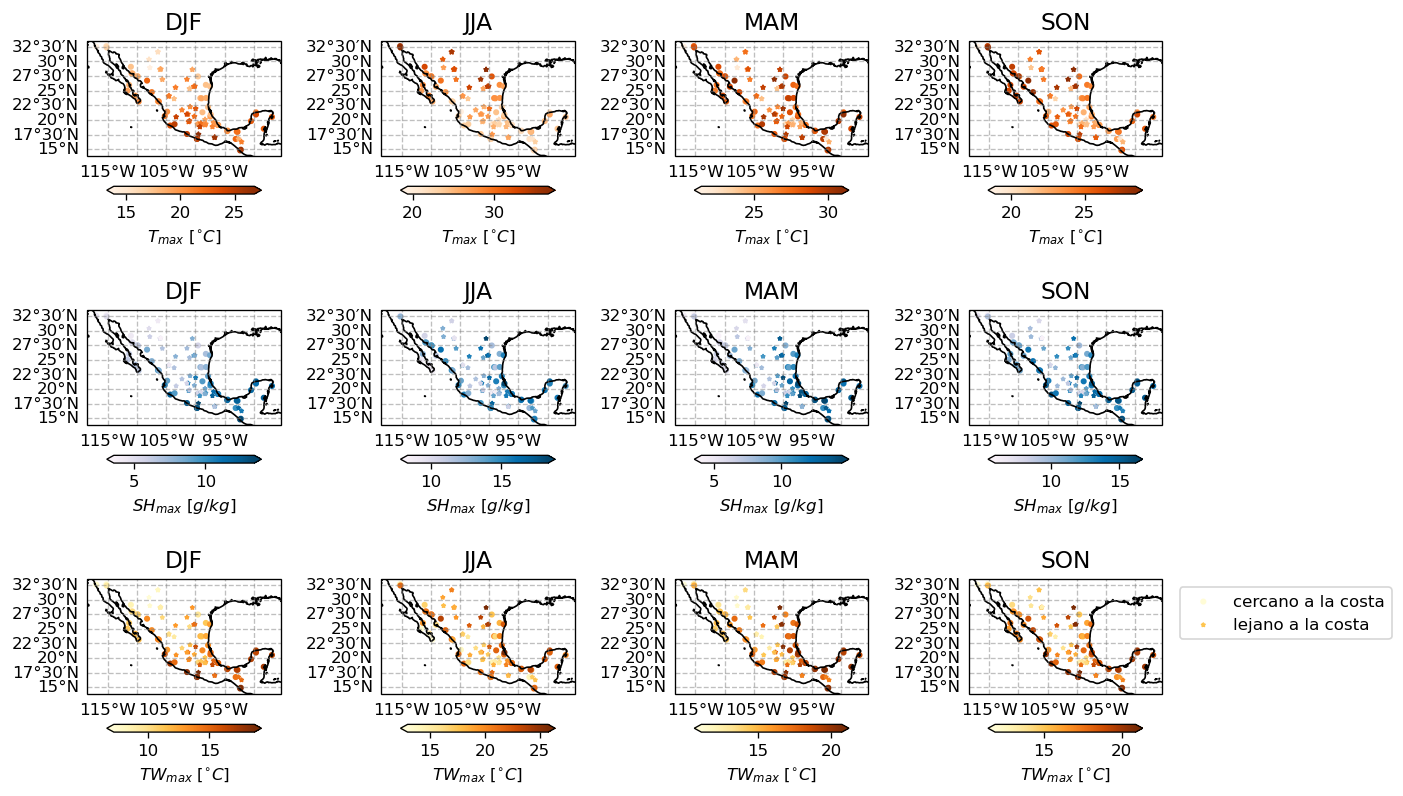

In [17]:
fig = plt.figure(figsize=(10, 7),dpi=120)
# definimos los levelss del mapa de colores
dat=Month.groupby("time.season").mean()
dat1=Month1.groupby("time.season").mean()
variables=["Tmax","SHmax","Twmax"]
labels=["$T_{max}$ $[^{\circ}C]$","$SH_{max}$ $[g/kg]$","$TW_{max}$ $[^{\circ}C]$"]
colors=["Oranges","PuBu","YlOrBr"]
n=1
for i,ii in enumerate(variables):
    for iseason,season in enumerate(dat.season):
        if ii=="Twmax":
            promedio_estacional=dat[ii].sel(season=season)-273.15
            promedio_estacional1=dat1[ii].sel(season=season)-273.15
            ax = fig.add_subplot(3, 4, n, projection=ccrs.PlateCarree())
            x=cluster0["Lon"].astype(float)
            y=cluster0["lat"].astype(float)
            x1=cluster1["Lon"].astype(float)
            y1=cluster1["lat"].astype(float)
            c=promedio_estacional
            c1=promedio_estacional1
            ax.coastlines()
            ccmap=cmr.get_sub_cmap(colors[i], 0.05, 0.95)
            #ccmap1=cmr.get_sub_cmap('autumn', 0.05, 0.95)
            cs=ax.scatter(x=x,y=y,c=c,cmap=ccmap,transform=ccrs.PlateCarree(),label="cercano a la costa",s=7)
            cs=ax.scatter(x=x1,y=y1,c=c1,cmap=ccmap,transform=ccrs.PlateCarree(),label="lejano a la costa",marker="*",s=5)
            gl=ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,color='gray', alpha=0.5, linestyle='--')
            ax.xlabels_top = False# It should turn off the upper x ticks
            gl.top_labels = gl.right_labels = False
            # colorbar
            cbar=plt.colorbar(cs,orientation="horizontal",fraction=0.1,extend="both",shrink=0.8)
            cbar.ax.set_xlabel(labels[i])
            # titulo del plot
            plt.title(np.array(season),fontsize=14)
        
            n=n+1
        elif ii=="SHmax":
            promedio_estacional=dat[ii].sel(season=season)*1000
            promedio_estacional1=dat1[ii].sel(season=season)*1000
            ax = fig.add_subplot(3, 4, n, projection=ccrs.PlateCarree())
            x=cluster0["Lon"].astype(float)
            y=cluster0["lat"].astype(float)
            x1=cluster1["Lon"].astype(float)
            y1=cluster1["lat"].astype(float)
            c=promedio_estacional
            c1=promedio_estacional1
            ax.coastlines()
            ccmap=cmr.get_sub_cmap(colors[i], 0.05, 0.95)
            #ccmap1=cmr.get_sub_cmap('autumn', 0.05, 0.95)
            cs=ax.scatter(x=x,y=y,c=c,cmap=ccmap,transform=ccrs.PlateCarree(),label="cercano a la costa",s=7)
            cs=ax.scatter(x=x1,y=y1,c=c1,cmap=ccmap,transform=ccrs.PlateCarree(),label="lejano a la costa",marker="*",s=5)
            gl=ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,color='gray', alpha=0.5, linestyle='--')
            ax.xlabels_top = False# It should turn off the upper x ticks
            gl.top_labels = gl.right_labels = False
            # colorbar
            cbar=plt.colorbar(cs,orientation="horizontal",fraction=0.1,extend="both",shrink=0.8)
            cbar.ax.set_xlabel(labels[i])
            # titulo del plot
            plt.title(np.array(season),fontsize=14)
        
            n=n+1
       
        else:
            
            
             # seleccionar la estacion
            promedio_estacional=dat[ii].sel(season=season)
            promedio_estacional1=dat1[ii].sel(season=season)
            # hacer el objeto multi-panel y seleccionar el panel correcto con el indice que varia en el ciclo iseason
            ax = fig.add_subplot(3, 4, n, projection=ccrs.PlateCarree())
            x=cluster0["Lon"].astype(float)
            y=cluster0["lat"].astype(float)
            x1=cluster1["Lon"].astype(float)
            y1=cluster1["lat"].astype(float)
            c=promedio_estacional
            c1=promedio_estacional1
            ax.coastlines()
            ccmap=cmr.get_sub_cmap(colors[i], 0.05, 0.95)
            #ccmap1=cmr.get_sub_cmap('autumn', 0.05, 0.95)
            cs=ax.scatter(x=x,y=y,c=c,cmap=ccmap,transform=ccrs.PlateCarree(),label="cercano a la costa",s=7)
            cs=ax.scatter(x=x1,y=y1,c=c1,cmap=ccmap,transform=ccrs.PlateCarree(),label="lejano a la costa",marker="*",s=7)
            gl=ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,color='gray', alpha=0.5, linestyle='--')
            ax.xlabels_top = False# It should turn off the upper x ticks
            gl.top_labels = gl.right_labels = False
            # colorbar
            cbar=plt.colorbar(cs,orientation="horizontal",fraction=0.1,extend="both",shrink=0.8)
            cbar.ax.set_xlabel(labels[i])
            # titulo del plot
            plt.title(np.array(season),fontsize=14)
           
            n=n+1
# ultimo arreglo, apretar el mapa
#fig.suptitle("Ciclo estacional de SH mean cluster0 (cercano a la costa)",fontsize=16)
plt.tight_layout(h_pad=1,pad=1.5)
plt.legend(bbox_to_anchor=(1.05, 1.0),loc="upper left")
plt.savefig("ciclo_estacional_porpunto.jpg")
plt.show()

In [18]:
#Separando los años de estudio para cada cluster
#El primer periodo será de 1979 al 2000

#Cluster0
#Seleccionamos dichos ID dentro de todos nuestros datos
Datos=seas.where(seas.estacion.isin(Id),drop=True)

#Seleccionamos el primer periodo de tiempo
mask01=(Datos.time.dt.year>=1979) & (Datos.time.dt.year<=2000)
P01=Datos.where(mask01,drop=True)

#Seleccionamos el segundo periodo de tiempo
mask02=(Datos.time.dt.year>=2001)
P02=Datos.where(mask02,drop=True)

In [19]:
#Realizando el ciclo anual para el cluster 0
#Periodo0
Mes=(P01.resample(time="M").mean()).groupby("time.month").mean()
anual0=Mes.mean("estacion")

#Periodo1
Mes1=(P02.resample(time="M").mean()).groupby("time.month").mean()
anual1=Mes1.mean("estacion")

/home/estudiantes/anaconda/lib/python3.11/site-packages/xarray/groupers.py:490: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(
/home/estudiantes/anaconda/lib/python3.11/site-packages/xarray/groupers.py:490: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  self.index_grouper = pd.Grouper(


In [34]:
P01

<xarray.Dataset> Size: 28MB
Dimensions:   (estacion: 49, time: 8036)
Coordinates:
  * time      (time) datetime64[ns] 64kB 1979-01-01 1979-01-02 ... 2000-12-31
  * estacion  (estacion) int64 392B 760013 760053 760400 ... 769030 769043
Data variables:
    Twmin     (estacion, time) float64 3MB nan nan nan nan ... nan nan nan nan
    Twmax     (estacion, time) float64 3MB nan nan nan nan ... nan nan nan nan
    Twmean    (estacion, time) float64 3MB nan nan nan nan ... nan nan nan nan
    Tmin      (estacion, time) float64 3MB nan nan nan nan ... nan nan nan nan
    Tmax      (estacion, time) float64 3MB nan nan nan nan ... nan nan nan nan
    Tmean     (estacion, time) float64 3MB nan nan nan nan ... nan nan nan nan
    SHmin     (estacion, time) float64 3MB nan nan nan nan ... nan nan nan nan
    SHmax     (estacion, time) float64 3MB nan nan nan nan ... nan nan nan nan
    SHmean    (estacion, time) float64 3MB nan nan nan nan ... nan nan nan nan
Attributes:
    description:  Estadísticos diarios:Twmax,Twmean,Tmax,Tmean,SHmax,SHmean

In [21]:
#Separando los años de estudio para cada cluster
#El primer periodo será de 1979 al 2000

#Seleccionamos dichos ID dentro de todos nuestros datos
Datos1=seas.where(seas.estacion.isin(Id1),drop=True)

#Seleccionamos el primer periodo de tiempo
mask11=(Datos1.time.dt.year>=1979) & (Datos1.time.dt.year<=2000)
P11=Datos1.where(mask11,drop=True)

#Seleccionamos el segundo periodo de tiempo
mask12=(Datos1.time.dt.year>=2001)
P12=Datos1.where(mask12,drop=True)

In [37]:
#Realizando el ciclo anual para el cluster 1
#Periodo0
Mes11=(P11.resample(time="ME").mean()).groupby("time.month").mean()
anual01=Mes11.mean("estacion")

#Periodo1
Mes12=(P12.resample(time="ME").mean()).groupby("time.month").mean()
anual02=Mes12.mean("estacion")

/tmp/ipykernel_140639/688091773.py:112: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_140639/688091773.py:68: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_140639/688091773.py:80: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_140639/688091773.py:41: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_140639/688091773.py:55: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


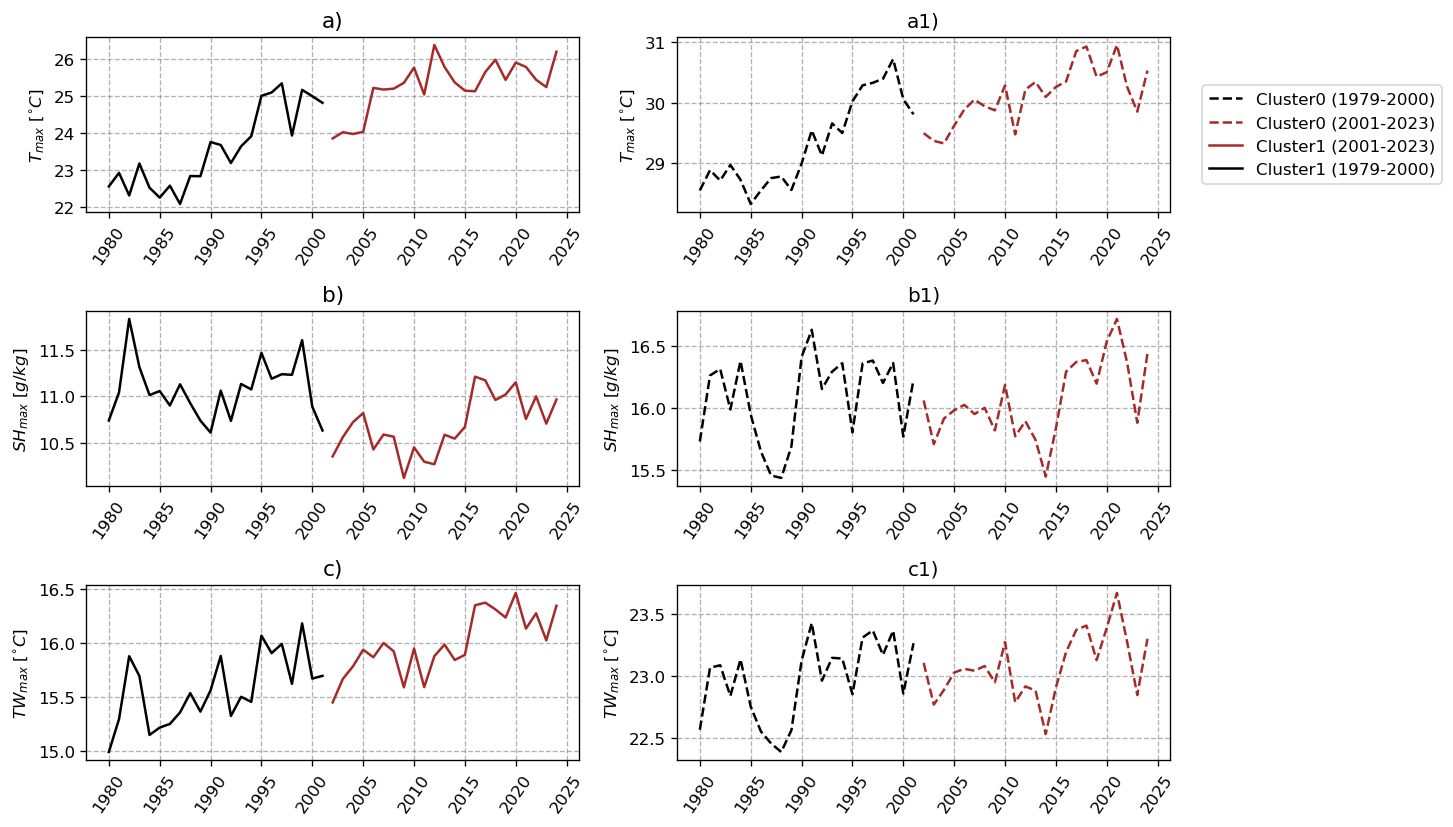

In [23]:
#Serie de tiempo por cluster y periodo de tiempo 
#Periodo1

#cluster0
mascara0=(P01.resample(time="ME").mean()).resample(time="YE").mean()
ser0=mascara0.mean("estacion")

#cluster1
mascara1=(P11.resample(time="ME").mean()).resample(time="YE").mean()
ser1=mascara1.mean("estacion")

#Periodo2

#cluster0
mascara01=(P02.resample(time="ME").mean()).resample(time="YE").mean()
ser01=mascara01.mean("estacion")

#Cluster1
mascara02=(P12.resample(time="ME").mean()).resample(time="YE").mean()
ser02=mascara02.mean("estacion")

#Graficando
datos=["a)","b)","c)"]
variables=["Tmax","SHmax","Twmax"]
labels=["$T_{max}$ $[^{\circ}C]$","$SH_{max}$ $[g/kg]$","$TW_{max}$ $[^{\circ}C]$"]
color=["black","black","brown","brown"]
linestyle=["--","--","-.","-."]
fig = plt.figure(figsize=(10, 7),dpi=120)
n=0

for ij,jj in enumerate(variables):
    if jj=="Twmax":
        plt.subplot(3,2,n+2)
        plt.plot(ser0[jj].time,ser0[jj]-273.15,color="black",linestyle="--",label="cercano a la costa (1979-2000)")
        plt.plot(ser01[jj].time,ser01[jj]-273.15,color="brown",linestyle="--",label="cercano a la costa (2001-2023)")
        plt.xticks(rotation=55)
        #plt.axhline(y=35,c='red',linewidth=3)
        plt.ylabel(labels[ij])
        plt.title("c1)")
        plt.grid(linestyle="--", color="grey",alpha=0.6)
        plt.tight_layout()
        
        
        
        
        plt.subplot(3,2,n+1)
        
        plt.plot(ser02[jj].time,ser02[jj]-273.15,color="brown",linestyle="-",label="lejano a la costa (2001-2023)")
        plt.plot(ser1[jj].time,ser1[jj]-273.15,color="black",linestyle="-",label="lejano a la costa (1979-2000)")
        plt.xticks(rotation=55)
        plt.ylabel(labels[ij])
        #plt.axhline(y=35,c='red',linewidth=3)
        plt.title(datos[ij],fontsize=13)
        plt.grid(linestyle="--", color="grey",alpha=0.6)
        plt.tight_layout()
       
        n=n+2

    elif jj=="SHmax":
        plt.subplot(3,2,n+2)
        plt.plot(ser0[jj].time,ser0[jj]*1000,color="black",linestyle="--",label="cercano a la costa (1979-2000)")
        plt.plot(ser01[jj].time,ser01[jj]*1000,color="brown",linestyle="--",label="cercano a la costa (2001-2023)")
        plt.xticks(rotation=55)
        plt.title("b1)")
       
        plt.ylabel(labels[ij])
        plt.grid(linestyle="--", color="grey",alpha=0.6)
        plt.tight_layout()
       
        
        
        plt.subplot(3,2,n+1)
        
        plt.plot(ser02[jj].time,ser02[jj]*1000,color="brown",linestyle="-",label="lejano a la costa (2001-2023)")
        plt.plot(ser1[jj].time,ser1[jj]*1000,color="black",linestyle="-",label="lejano a la costa (1979-2000)")
        plt.xticks(rotation=55)
        plt.ylabel(labels[ij])
        plt.title(datos[ij],fontsize=13)
        plt.grid(linestyle="--", color="grey",alpha=0.6)
        plt.tight_layout()
       
       
        n=n+2
    
    else:
        plt.subplot(3,2,n+2)
        a,=plt.plot(ser0[jj].time,ser0[jj],color="black",linestyle="--",label="Cluster0 (1979-2000)")
        b,=plt.plot(ser01[jj].time,ser01[jj],color="brown",linestyle="--",label="Cluster0 (2001-2023)")
        plt.xticks(rotation=55)
        plt.ylabel(labels[ij])
        plt.title("a1)")
        plt.grid(linestyle="--", color="grey",alpha=0.6)
        plt.tight_layout()
        
        
        
        
        plt.subplot(3,2,n+1)
        
        c,=plt.plot(ser02[jj].time,ser02[jj],color="brown",linestyle="-",label="Cluster1 (2001-2023)")
        d,=plt.plot(ser1[jj].time,ser1[jj],color="black",linestyle="-",label="Cluster1 (1979-2000)")
        plt.xticks(rotation=55)
        plt.ylabel(labels[ij])
       
        plt.title(datos[ij],fontsize=13)
        plt.grid(linestyle="--", color="grey",alpha=0.6)
        fig.legend(handles=[a, b,c,d], 
           loc="upper left",  # Ubicación (ajústalo según necesites)
           bbox_to_anchor=(1, 0.9),  # Ajusta la posición fuera de los gráficos
           ncol=1,  # Número de columnas en la leyenda
           frameon=True)  # Sin borde
        plt.tight_layout()
        n=n+2
        
plt.savefig("serietemporalporperiodo.svg")        


In [33]:
anual0

<xarray.Dataset> Size: 960B
Dimensions:  (month: 12)
Coordinates:
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    Twmin    (month) float64 96B 287.6 287.9 289.0 291.0 ... 293.4 290.6 288.4
    Twmax    (month) float64 96B 292.2 292.7 293.6 295.3 ... 297.0 294.8 292.7
    Twmean   (month) float64 96B 289.9 290.4 291.4 293.3 ... 295.3 292.8 290.6
    Tmin     (month) float64 96B 16.33 16.9 18.29 20.66 ... 22.48 19.53 17.25
    Tmax     (month) float64 96B 24.65 25.9 27.49 29.99 ... 29.97 27.52 24.89
    Tmean    (month) float64 96B 20.41 21.38 22.91 25.43 ... 26.19 23.49 20.97
    SHmin    (month) float64 96B 0.009699 0.009745 0.01034 ... 0.01183 0.01032
    SHmax    (month) float64 96B 0.0124 0.01255 0.01331 ... 0.01476 0.01297
    SHmean   (month) float64 96B 0.01103 0.01113 0.01181 ... 0.01327 0.01163

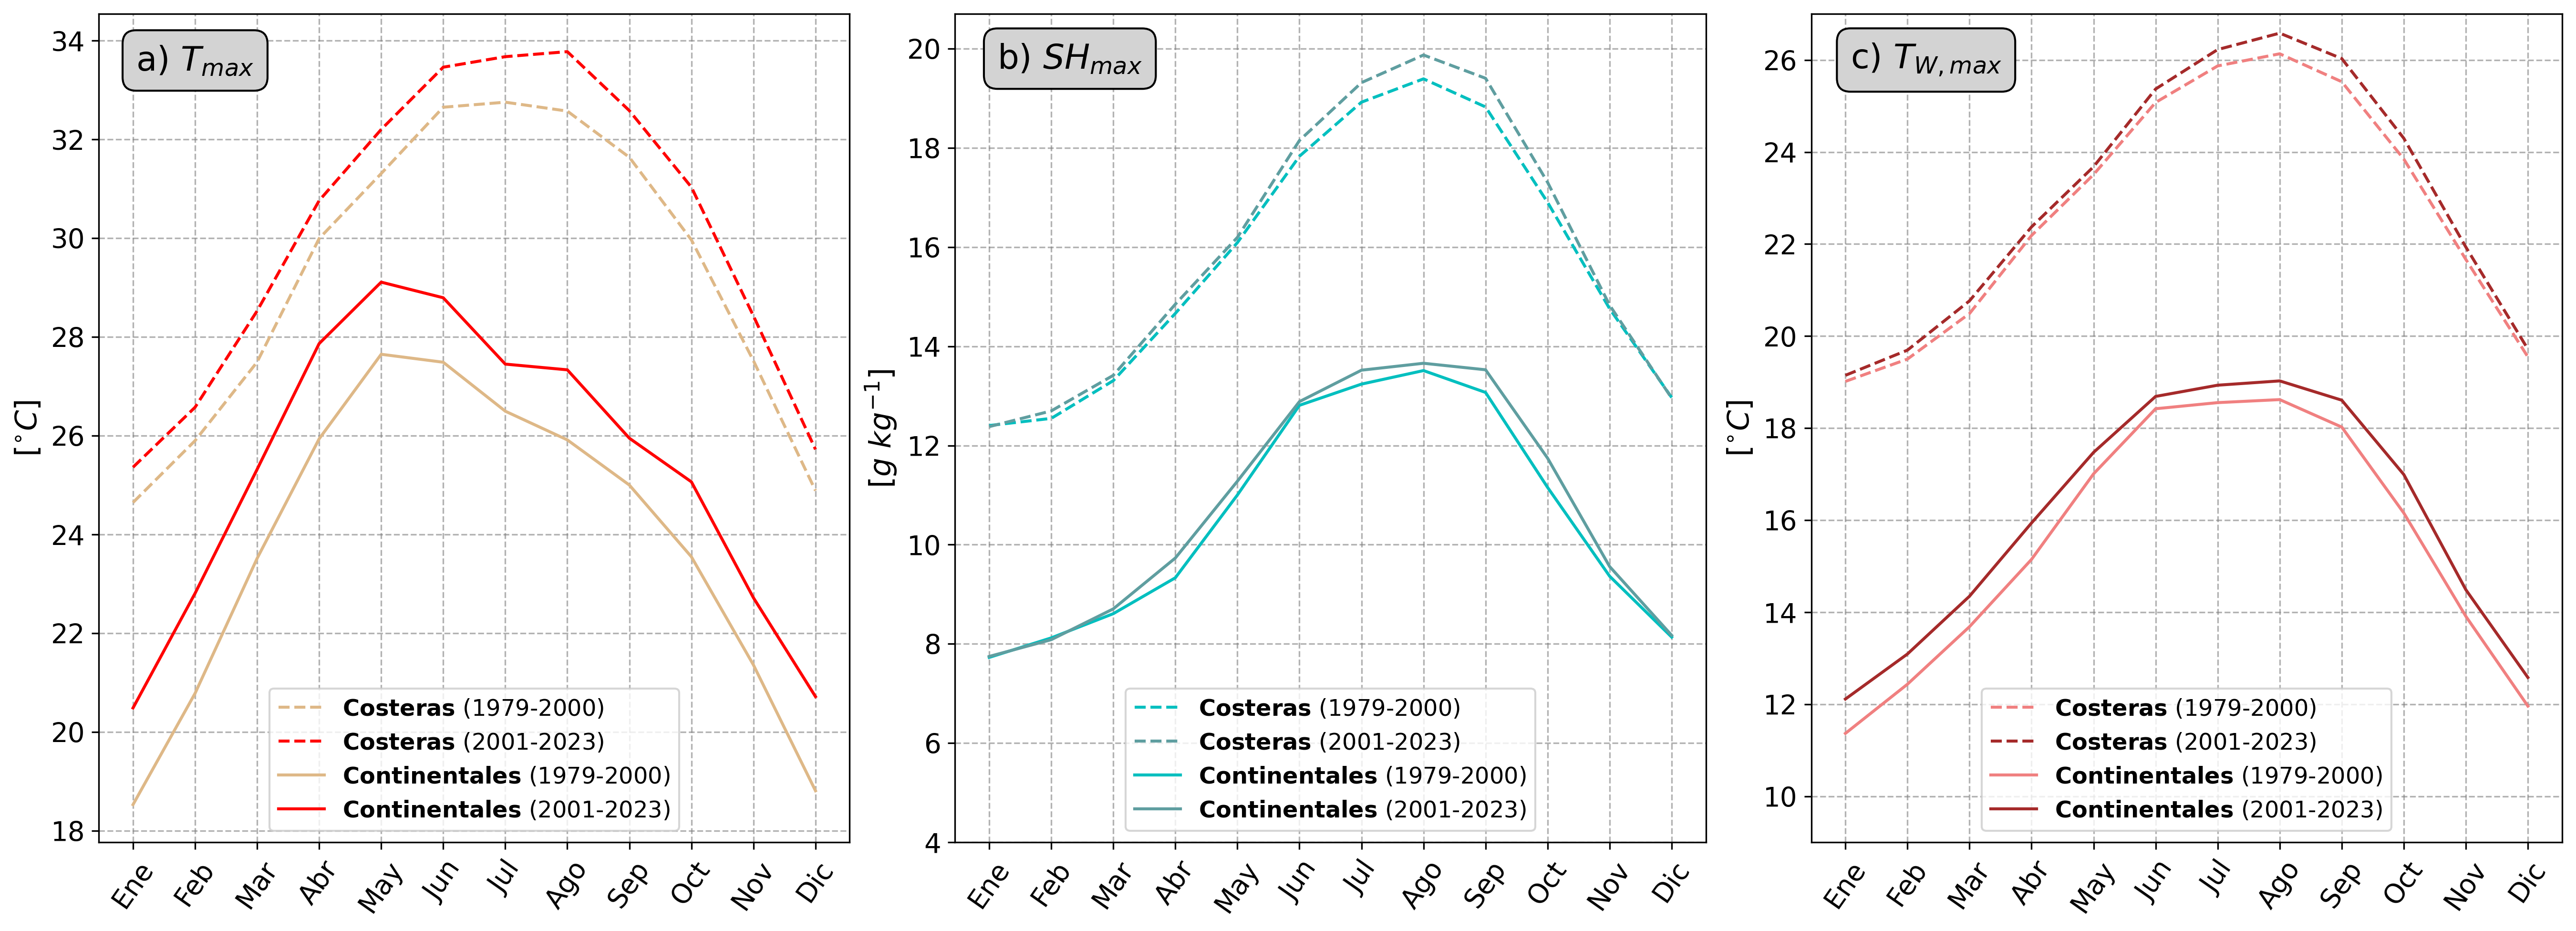

In [39]:
#Graficando en multipanel de las 6 variables
import cmasher as cmr
fig = plt.figure(figsize=(18,6.5),dpi=300)
meses=['Ene','Feb','Mar','Abr','May','Jun','Jul', 'Ago','Sep','Oct','Nov','Dic']
variables=["Tmax","SHmax","Twmax"]
datos=["a)","b)","c)"]
labels=["[$^{\circ}C$]","[$g$ $kg^{-1}$]","[$^{\circ}C$]"]
color=["#DEB887","red","#00BFBF","#5F9EA0","#F08080","#A52A2A"]
linestyles=["--","-"]
# definimos los levelss del mapa de colores

for ivar,var in enumerate(variables): 
    if var=="Twmax":
        plt.subplot(1,3,3)
        plt.plot(meses,anual0[var]-273.15,linestyle=linestyles[0],color=color[4],label=r"$\mathbf{Costeras}$ (1979-2000)")
        plt.plot(meses,anual1[var]-273.15,linestyle=linestyles[0],color=color[5],label=r"$\mathbf{Costeras}$ (2001-2023)")
        plt.plot(meses,anual01[var]-273.15,linestyle=linestyles[1],color=color[4],label=r"$\mathbf{Continentales}$ (1979-2000)")
        plt.plot(meses,anual02[var]-273.15,linestyle=linestyles[1],color=color[5],label=r"$\mathbf{Continentales}$ (2001-2023)") 
        plt.xticks(rotation=55,fontsize=13.5)
        plt.yticks(fontsize=13.5)
        plt.ylim(9,27)
        #plt.axhline(y=35,c='red',linewidth=3)
        plt.ylabel(labels[ivar],fontsize=15)
        plt.text(1.3, 26, "c) $T_{W,max}$", fontsize=17, color="black", ha="center", va="center",
                 bbox=dict(facecolor="lightgray", edgecolor="black", boxstyle="round",pad=0.4))
        plt.grid(linestyle="--", color="grey",alpha=0.6)
        plt.legend(fontsize=11.5)
       
        
    elif var=="SHmax":
        plt.subplot(1,3,2)
        plt.plot(meses,anual0[var]*1000,linestyle=linestyles[0],color=color[2],label=r"$\mathbf{Costeras}$ (1979-2000)")
        plt.plot(meses,anual1[var]*1000,linestyle=linestyles[0],color=color[3],label=r"$\mathbf{Costeras}$ (2001-2023)")
        plt.plot(meses,anual01[var]*1000,linestyle=linestyles[1],color=color[2],label=r"$\mathbf{Continentales}$ (1979-2000)")
        plt.plot(meses,anual02[var]*1000,linestyle=linestyles[1],color=color[3],label=r"$\mathbf{Continentales}$ (2001-2023)") 
        plt.xticks(rotation=55,fontsize=13.5)
        plt.yticks(fontsize=13.5)
        plt.ylim(4,20.7)
        plt.ylabel(labels[ivar],fontsize=15)
        plt.text(1.3, 19.8, "b) $SH_{max}$", fontsize=17, color="black", ha="center", va="center",
                 bbox=dict(facecolor="lightgray", edgecolor="black", boxstyle="round",pad=0.4))
        plt.grid(linestyle="--", color="grey",alpha=0.6)
        plt.legend(fontsize=11.5,loc="lower center")
       

    else:
        plt.subplot(1,3,1)
        a,=plt.plot(meses,anual0[var],linestyle=linestyles[0],color=color[0],label=r"$\mathbf{Costeras}$ (1979-2000)")
        b,=plt.plot(meses,anual1[var],linestyle=linestyles[0],color=color[1],label=r"$\mathbf{Costeras}$ (2001-2023)")
        c,=plt.plot(meses,anual01[var],linestyle=linestyles[1],color=color[0],label=r"$\mathbf{Continentales}$ (1979-2000)")
        d,=plt.plot(meses,anual02[var],linestyle=linestyles[1],color=color[1],label=r"$\mathbf{Continentales}$ (2001-2023)") 
        plt.xticks(rotation=55,fontsize=13.5)
        plt.yticks(fontsize=13.5)
        plt.ylabel(labels[ivar],fontsize=15)
        plt.text(1, 33.6, "a) $T_{max}$", fontsize=17, color="black", ha="center", va="center",
                 bbox=dict(facecolor="lightgray", edgecolor="black", boxstyle="round",pad=0.4))
        plt.grid(linestyle="--", color="grey",alpha=0.6)  
        plt.legend(fontsize=11.5)
plt.tight_layout(pad=0.7)
        
        
plt.savefig("Ciclo_anual_porclusteryperiodo.svg",bbox_inches="tight",dpi=300)      
plt.savefig("Ciclo_anual_porclusteryperiodo.png",bbox_inches="tight",dpi=300)    



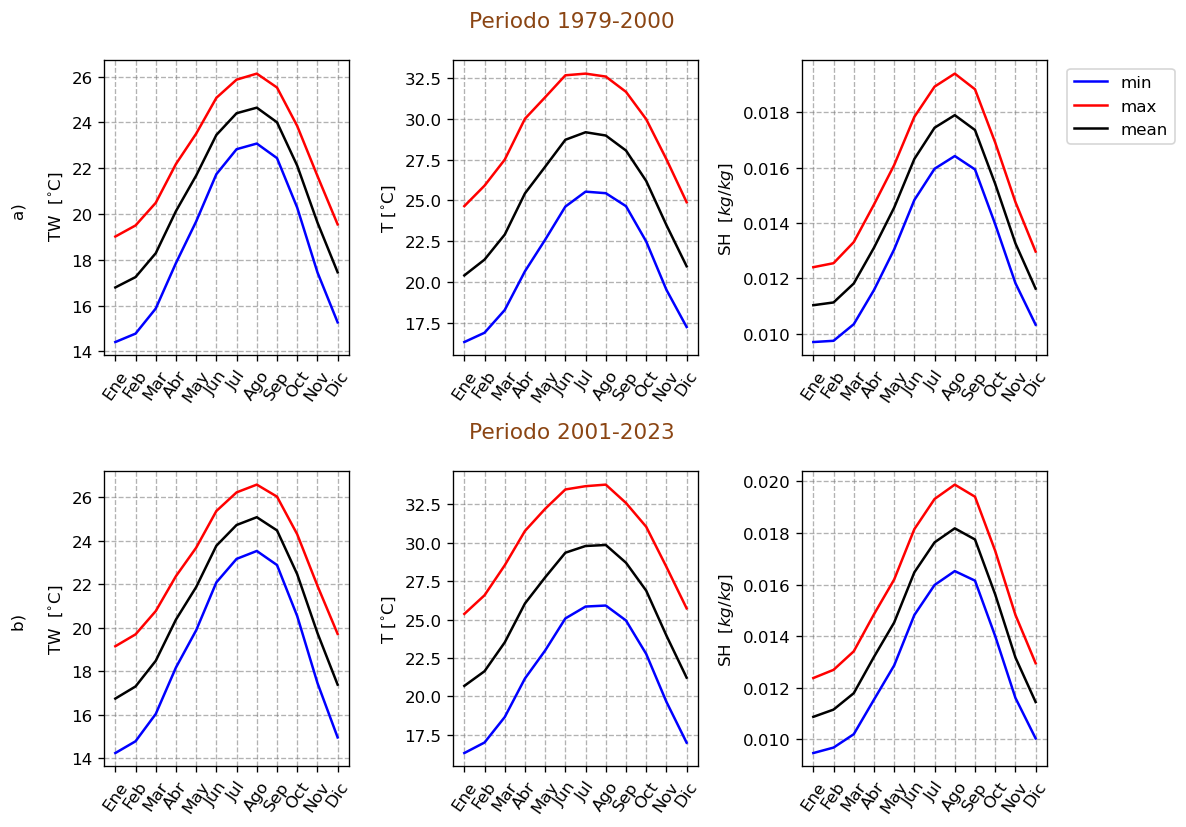

In [26]:
#Ciclo anual para el cluster 0
import cmasher as cmr
fig = plt.figure(figsize=(10, 7),dpi=120)
meses=['Ene','Feb','Mar','Abr','May','Jun','Jul', 'Ago','Sep','Oct','Nov','Dic']
label=["min","max","mean","min","max","mean","min","max","mean"]
color=["blue","red","black","blue","red","black","blue","red","black"]
# definimos los levelss del mapa de colores
for ivar,var in enumerate(anual0.variables):
    #print(ivar,var)
     # seleccionar la estacion
    if ivar<=2:
        plt.subplot(2, 3, 1)
        anu=anual0[var]
        plt.plot(meses,anu-273.15,label=label[ivar],color=color[ivar])
        plt.xticks(rotation=55)
        plt.ylabel("a) \n \n TW  $[^{\circ}$C]")
        plt.grid(linestyle="--", color="grey",alpha=0.6)
    

        plt.subplot(2, 3, 4)
        anu1=anual1[var]
        plt.plot(meses,anu1-273.15,label=label[ivar],color=color[ivar])
        plt.xticks(rotation=55)
        plt.ylabel("b) \n \nTW  $[^{\circ}$C]")
        plt.grid(linestyle="--", color="grey",alpha=0.6)
        
    
    elif ivar>=3 and ivar <=5:
        plt.subplot(2, 3, 2)
        anu1=anual0[var]
        plt.plot(meses,anu1,label=label[ivar],color=color[ivar])
        plt.xticks(rotation=55)
        plt.ylabel("T $[^{\circ}$C]")
        plt.title("Periodo 1979-2000 \n", color="saddlebrown",fontsize=13)
        plt.xlabel("\n\n")
        plt.grid(linestyle="--", color="grey",alpha=0.6)

        plt.subplot(2, 3, 5)
        anu2=anual1[var]
        plt.plot(meses,anu2,label=label[ivar],color=color[ivar])
        plt.xticks(rotation=55)
        plt.ylabel("T $[^{\circ}$C]")
        plt.title("Periodo 2001-2023 \n", color="saddlebrown",fontsize=13)
        plt.grid(linestyle="--", color="grey",alpha=0.6)
   
            
    elif ivar>=6 and ivar<=8:
        plt.subplot(2, 3, 3)
        anu2=anual0[var]
        plt.plot(meses,anu2,label=label[ivar],color=color[ivar])
        plt.xticks(rotation=55)
        plt.ylabel("SH  $[kg/kg]$")
        plt.legend(bbox_to_anchor=(1.05, 1.0),loc="upper left")
        plt.grid(linestyle="--", color="grey",alpha=0.6)

        
        plt.subplot(2, 3, 6)
        anu3=anual1[var]
        plt.plot(meses,anu3,label=label[ivar],color=color[ivar])
        plt.xticks(rotation=55)
        plt.ylabel("SH  $[kg/kg]$")
        plt.grid(linestyle="--", color="grey",alpha=0.6)




plt.tight_layout()
plt.savefig("ciclo_anual_0.jpg")
plt.show()
           


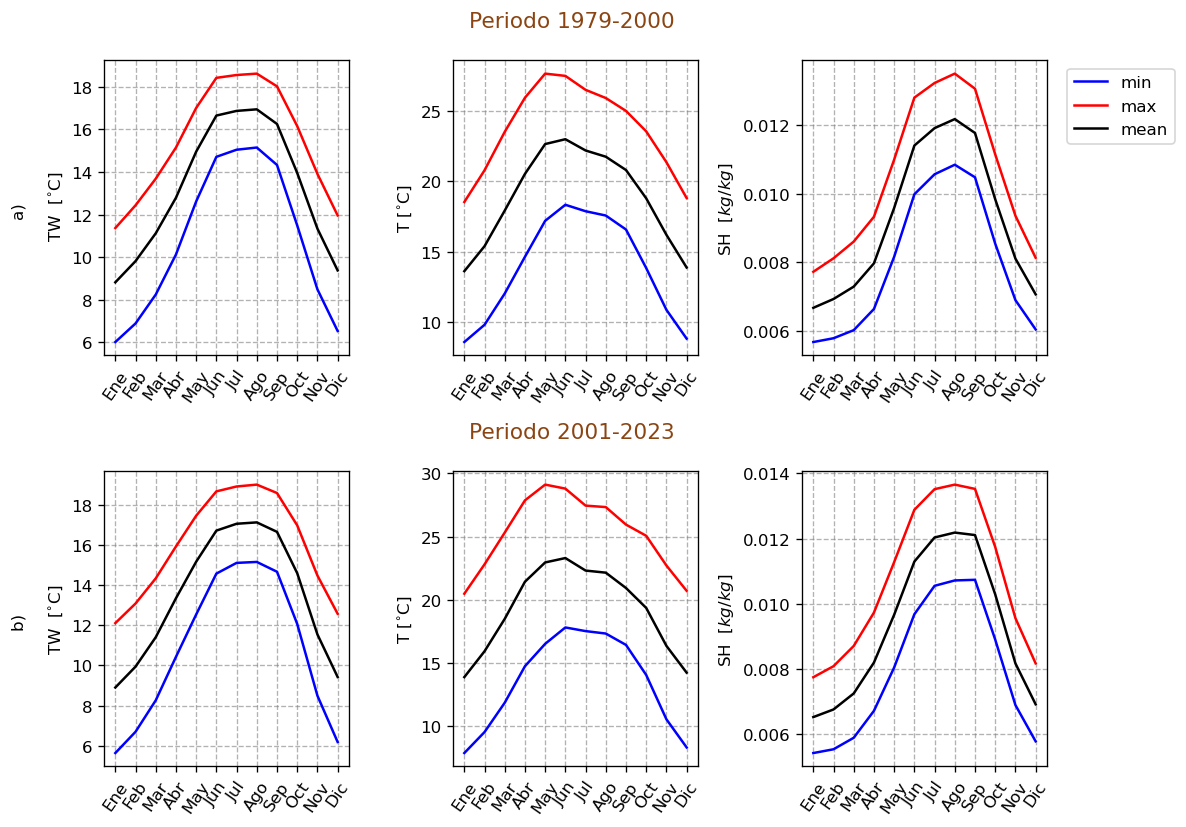

In [27]:
#Ciclo anual para el cluster 1
import cmasher as cmr
fig = plt.figure(figsize=(10, 7),dpi=120)
meses=['Ene','Feb','Mar','Abr','May','Jun','Jul', 'Ago','Sep','Oct','Nov','Dic']
label=["min","max","mean","min","max","mean","min","max","mean"]
color=["blue","red","black","blue","red","black","blue","red","black"]
# definimos los levelss del mapa de colores
for ivar,var in enumerate(anual01.variables):
    #print(ivar,var)
     # seleccionar la estacion
    if ivar<=2:
        plt.subplot(2, 3, 1)
        anu=anual01[var]
        plt.plot(meses,anu-273.15,label=label[ivar],color=color[ivar])
        plt.xticks(rotation=55)
        plt.ylabel("a) \n \n TW  $[^{\circ}$C]")
        plt.grid(linestyle="--", color="grey",alpha=0.6)
    

        plt.subplot(2, 3, 4)
        anu1=anual02[var]
        plt.plot(meses,anu1-273.15,label=label[ivar],color=color[ivar])
        plt.xticks(rotation=55)
        plt.ylabel("b) \n \nTW  $[^{\circ}$C]")
        plt.grid(linestyle="--", color="grey",alpha=0.6)
        
    
    elif ivar>=3 and ivar <=5:
        plt.subplot(2, 3, 2)
        anu1=anual01[var]
        plt.plot(meses,anu1,label=label[ivar],color=color[ivar])
        plt.xticks(rotation=55)
        plt.ylabel("T $[^{\circ}$C]")
        plt.title("Periodo 1979-2000 \n", color="saddlebrown",fontsize=13)
        plt.xlabel("\n\n")
        plt.grid(linestyle="--", color="grey",alpha=0.6)

        plt.subplot(2, 3, 5)
        anu2=anual02[var]
        plt.plot(meses,anu2,label=label[ivar],color=color[ivar])
        plt.xticks(rotation=55)
        plt.ylabel("T $[^{\circ}$C]")
        plt.title("Periodo 2001-2023 \n", color="saddlebrown",fontsize=13)
        plt.grid(linestyle="--", color="grey",alpha=0.6)
   
            
    elif ivar>=6 and ivar<=8:
        plt.subplot(2, 3, 3)
        anu2=anual01[var]
        plt.plot(meses,anu2,label=label[ivar],color=color[ivar])
        plt.xticks(rotation=55)
        plt.ylabel("SH  $[kg/kg]$")
        plt.legend(bbox_to_anchor=(1.05, 1.0),loc="upper left")
        plt.grid(linestyle="--", color="grey",alpha=0.6)

        
        plt.subplot(2, 3, 6)
        anu3=anual02[var]
        plt.plot(meses,anu3,label=label[ivar],color=color[ivar])
        plt.xticks(rotation=55)
        plt.ylabel("SH  $[kg/kg]$")
        plt.grid(linestyle="--", color="grey",alpha=0.6)

plt.tight_layout()
plt.savefig("ciclo_anual_1.jpg")
plt.show()
           


/tmp/ipykernel_140639/3136155330.py:145: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_140639/3136155330.py:87: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_140639/3136155330.py:107: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_140639/3136155330.py:48: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_140639/3136155330.py:67: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


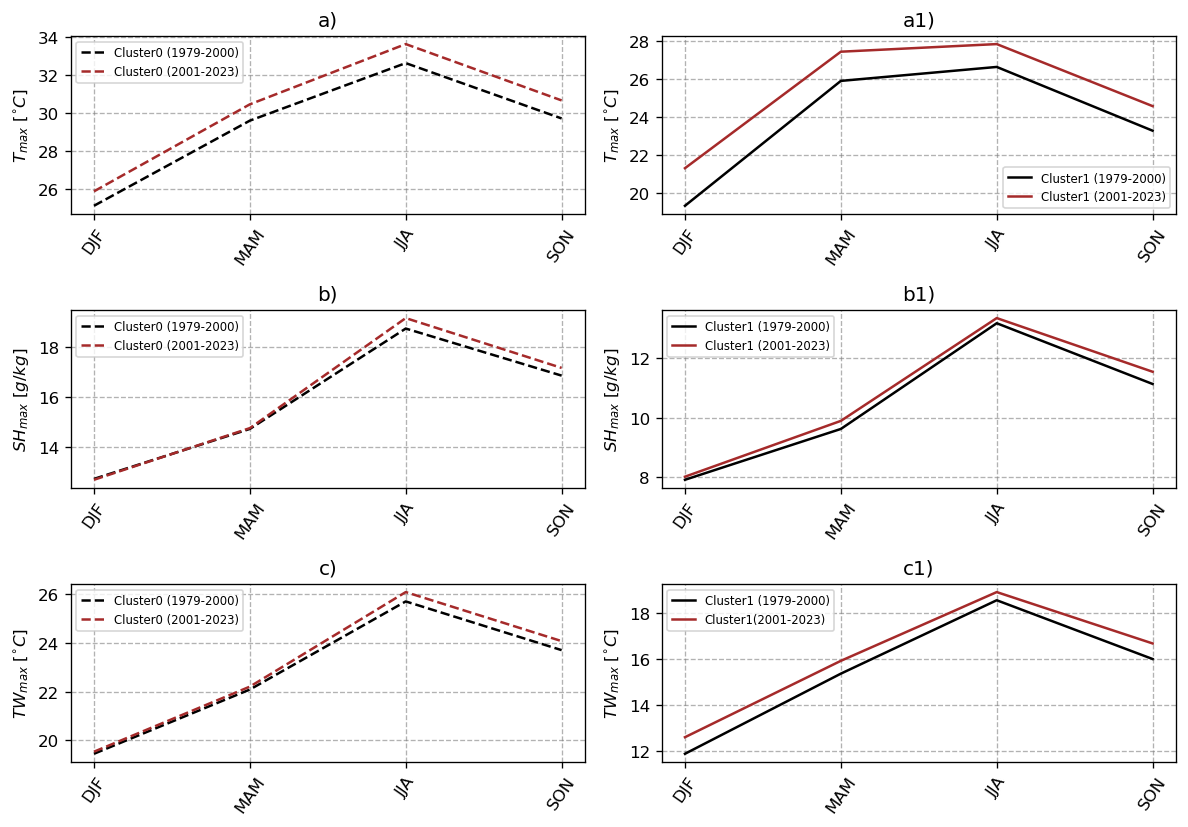

In [28]:
#Ciclo estacional por cluster
cluster_01_esta=P01.groupby(P01.time.dt.season).mean()
cluster_02_esta=P02.groupby(P02.time.dt.season).mean()

#Periodo1
#cluster0
mascara0=P01.groupby("time.season").mean()
ser0=mascara0.mean("estacion")
#cluster1
mascara1=P11.groupby("time.season").mean()
ser1=mascara1.mean("estacion")

#Periodo2

#cluster0
mascara01=P02.groupby("time.season").mean()
ser01=mascara01.mean("estacion")

mascara02=P12.groupby("time.season").mean()
ser02=mascara02.mean("estacion")


datos=["a)","b)","c)"]
variables=["Tmax","SHmax","Twmax"]
labels=["$T_{max}$ $[^{\circ}C]$","$SH_{max}$ $[g/kg]$","$TW_{max}$ $[^{\circ}C]$"]
seaso=["DJF","MAM","JJA","SON"]

fig = plt.figure(figsize=(10, 7),dpi=120)
n=0
for ij,jj in enumerate(variables):
    if jj=="Twmax":
        plt.subplot(3,2,n+1)
        es=ser0[jj]-273.15

        es1=ser01[jj]-273.15
        
        season=[es[0],es[2],es[1],es[3]]
        season1=[es1[0],es1[2],es1[1],es1[3]]
    
        plt.plot(seaso,season,color="black",linestyle="--",label="Cluster0 (1979-2000)")
        plt.plot(seaso,season1,color="brown",linestyle="--",label="Cluster0 (2001-2023)")
       # plt.axhline(y=35,c='red',linewidth=3)
        plt.xticks(rotation=55)
        plt.ylabel(labels[ij])
        plt.title("c)")
        plt.grid(linestyle="--", color="grey",alpha=0.6)
        plt.legend(fontsize=7)
        plt.tight_layout()
        

        plt.subplot(3,2,n+2)
        es1=ser1[jj]-273.15

        es11=ser02[jj]-273.15
        
        season=[es1[0],es1[2],es1[1],es1[3]]
        season1=[es11[0],es11[2],es11[1],es11[3]]
    
        plt.plot(seaso,season,color="black",linestyle="-",label="Cluster1 (1979-2000)")
        plt.plot(seaso,season1,color="brown",linestyle="-",label="Cluster1(2001-2023)")
        #plt.axhline(y=35,c='red',linewidth=3)
        plt.xticks(rotation=55)
        plt.ylabel(labels[ij])
        plt.title("c1)")
        plt.grid(linestyle="--", color="grey",alpha=0.6)
        plt.legend(fontsize=7)
        plt.tight_layout()
        n=n+2

    elif jj=="SHmax":
        plt.subplot(3,2,n+1)
        es=ser0[jj]*1000

        es1=ser01[jj]*1000
        
        season=[es[0],es[2],es[1],es[3]]
        season1=[es1[0],es1[2],es1[1],es1[3]]
    
        plt.plot(seaso,season,color="black",linestyle="--",label="Cluster0 (1979-2000)")
        plt.plot(seaso,season1,color="brown",linestyle="--",label="Cluster0 (2001-2023)")
        
        plt.xticks(rotation=55)
        plt.ylabel(labels[ij])
        plt.title("b)")
        plt.grid(linestyle="--", color="grey",alpha=0.6)
        plt.legend(fontsize=7)
        plt.tight_layout()
        
         
        plt.subplot(3,2,n+2)
        
        es1=ser1[jj]*1000

        es11=ser02[jj]*1000
        
        season=[es1[0],es1[2],es1[1],es1[3]]
        season1=[es11[0],es11[2],es11[1],es11[3]]
    
        plt.plot(seaso,season,color="black",linestyle="-",label="Cluster1 (1979-2000)")
        plt.plot(seaso,season1,color="brown",linestyle="-",label="Cluster1 (2001-2023)")
       
        plt.xticks(rotation=55)
        plt.ylabel(labels[ij])
        plt.title("b1)")
        plt.grid(linestyle="--", color="grey",alpha=0.6)
        plt.legend(fontsize=7)
        plt.tight_layout()
        n=n+2

    else:
        plt.subplot(3,2,n+1)
        es=ser0[jj]

        es1=ser01[jj]
        
        season=[es[0],es[2],es[1],es[3]]
        season1=[es1[0],es1[2],es1[1],es1[3]]
    
        plt.plot(seaso,season,color="black",linestyle="--",label="Cluster0 (1979-2000)")
        plt.plot(seaso,season1,color="brown",linestyle="--",label="Cluster0 (2001-2023)")
        
        plt.xticks(rotation=55)
        plt.ylabel(labels[ij])
        plt.title("a)")
        plt.grid(linestyle="--", color="grey",alpha=0.6)
        plt.legend(fontsize=7)
        plt.tight_layout()
        
         
        plt.subplot(3,2,n+2)
        es1=ser1[jj]

        es11=ser02[jj]
        
        season=[es1[0],es1[2],es1[1],es1[3]]
        season1=[es11[0],es11[2],es11[1],es11[3]]
    
        plt.plot(seaso,season,color="black",linestyle="-",label="Cluster1 (1979-2000)")
        plt.plot(seaso,season1,color="brown",linestyle="-",label="Cluster1 (2001-2023)")
        plt.xticks(rotation=55)
        plt.ylabel(labels[ij])
        plt.title("a1)")
        plt.grid(linestyle="--", color="grey",alpha=0.6)
        plt.legend(fontsize=7)
        plt.tight_layout()
        n=n+2
    
plt.savefig("ciclo_estacional_clusterperiodo.svg")      
       
    

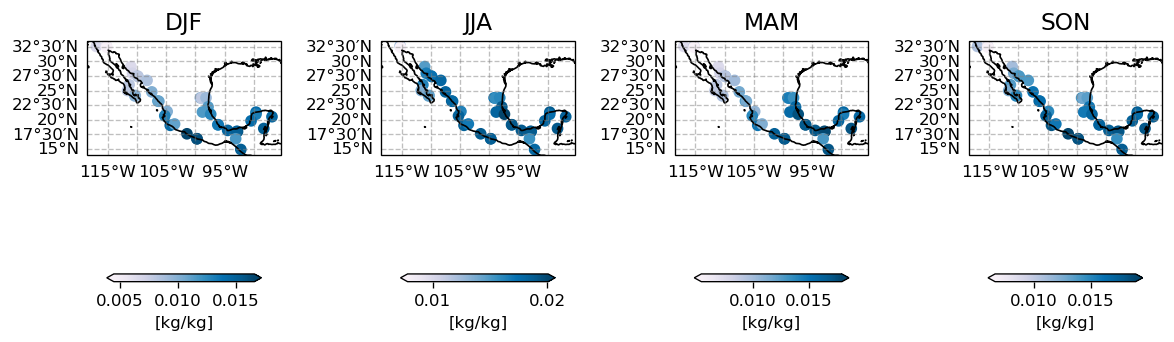

In [29]:
fig = plt.figure(figsize=(10, 7),dpi=120)
# definimos los levelss del mapa de colores
for iseason,season in enumerate(cluster_01_esta.season):
     # seleccionar la estacion
    promedio_estacional=cluster_01_esta.SHmean.sel(season=season)
    # hacer el objeto multi-panel y seleccionar el panel correcto con el indice que varia en el ciclo iseason
    ax = fig.add_subplot(1, 4, 1+iseason, projection=ccrs.PlateCarree())
    x=cluster0["Lon"].astype(float)
    y=cluster0["lat"].astype(float)
    c=promedio_estacional
    ax.coastlines()
    ccmap=cmr.get_sub_cmap('PuBu', 0.05, 0.95)
    cs=ax.scatter(x=x,y=y,c=c,cmap=ccmap,transform=ccrs.PlateCarree())
    gl=ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False,color='gray', alpha=0.5, linestyle='--')
    ax.xlabels_top = False# It should turn off the upper x ticks
    gl.top_labels = gl.right_labels = False
    # colorbar
    cbar=plt.colorbar(cs,orientation="horizontal",fraction=0.1,extend="both",shrink=0.8)
    cbar.ax.set_xlabel('[kg/kg]')
    # titulo del plot
    plt.title(season.data,fontsize=14)
# ultimo arreglo, apretar el mapa
#fig.suptitle("Ciclo estacional de SH mean cluster0 (cercano a la costa)",fontsize=16)
plt.tight_layout(h_pad=1,pad=1.5)
plt.show()

In [30]:
#Regresiones lineales
import statsmodels.api as sm
import statsmodels.formula.api as smf


In [31]:
#Recordando que los años a analizar es de 1979-2023
#Tienen datos vacíos en algunos años

#Regresión lineal por variable
regall=seas[["Tmax","SHmax","Twmax"]].where(Datos[["Tmax","SHmax","Twmax"]].time.dt.year>=1979,drop=True)
Tiempoall=regall.resample(time="YE").mean().time.dt.year
tmaxall=regall.Tmax.resample(time="YE").mean()
shmaxall=regall.SHmax.resample(time="YE").mean()
twmaxall=regall.Twmax.resample(time="YE").mean()

p=np.array(tmaxall.mean("estacion"))
p1=np.array(shmaxall.mean("estacion"))
p2=np.array(twmaxall.mean("estacion"))
# Añadir una constante para el término de intersección en el modelo
X = sm.add_constant(np.float64(Tiempoall))

# Ajustar el modelo de regresión lineal utilizando OLS (Mínimos cuadrados ordinarios)
modeloall1 = sm.OLS(p, X).fit()
modeloall2=sm.OLS(p1*1000, X).fit()
modeloall3=sm.OLS(p2, X).fit()

#Regresión lineal por cluster
#Cluster0
reg0=Datos[["Tmax","SHmax","Twmax"]].where(Datos[["Tmax","SHmax","Twmax"]].time.dt.year>=1979,drop=True)
Tiempo0=reg0.resample(time="YE").mean().time.dt.year
tmaxreg0=reg0.Tmax.resample(time="YE").mean()
shmaxreg0=reg0.SHmax.resample(time="YE").mean()
twmaxreg0=reg0.Twmax.resample(time="YE").mean()

# Añadir una constante para el término de intersección en el modelo
X1 = sm.add_constant(np.float64(Tiempo0))

TMAX_cluster0=np.array(tmaxreg0.mean("estacion"))
SHMAX_cluster0=np.array(shmaxreg0.mean("estacion"))
TWMAX_cluster0=np.array(twmaxreg0.mean("estacion"))
# Ajustar el modelo de regresión lineal utilizando OLS (Mínimos cuadrados ordinarios)
tmax_cluster0 = sm.OLS(TMAX_cluster0, X1).fit()
shmax_cluster0=sm.OLS(SHMAX_cluster0*1000, X1).fit()
twmax_cluster0=sm.OLS(TWMAX_cluster0, X1).fit()

#Cluster1
reg1=Datos1[["Tmax","SHmax","Twmax"]].where(Datos1[["Tmax","SHmax","Twmax"]].time.dt.year>=1979,drop=True)
Tiempo1=reg1.resample(time="YE").mean().time.dt.year
tmaxreg1=reg1.Tmax.resample(time="YE").mean()
shmaxreg1=reg1.SHmax.resample(time="YE").mean()
twmaxreg1=reg1.Twmax.resample(time="YE").mean()


TMAX_cluster1=np.array(tmaxreg1.mean("estacion"))
SHMAX_cluster1=np.array(shmaxreg1.mean("estacion"))
TWMAX_cluster1=np.array(twmaxreg1.mean("estacion"))

# Añadir una constante para el término de intersección en el modelo
X2 = sm.add_constant(np.float64(Tiempo1))

# Ajustar el modelo de regresión lineal utilizando OLS (Mínimos cuadrados ordinarios)
tmax_cluster1 = sm.OLS(TMAX_cluster1, X2).fit()
shmax_cluster1=sm.OLS(SHMAX_cluster1*1000, X2).fit()
twmax_cluster1=sm.OLS(TWMAX_cluster1 ,X2).fit()

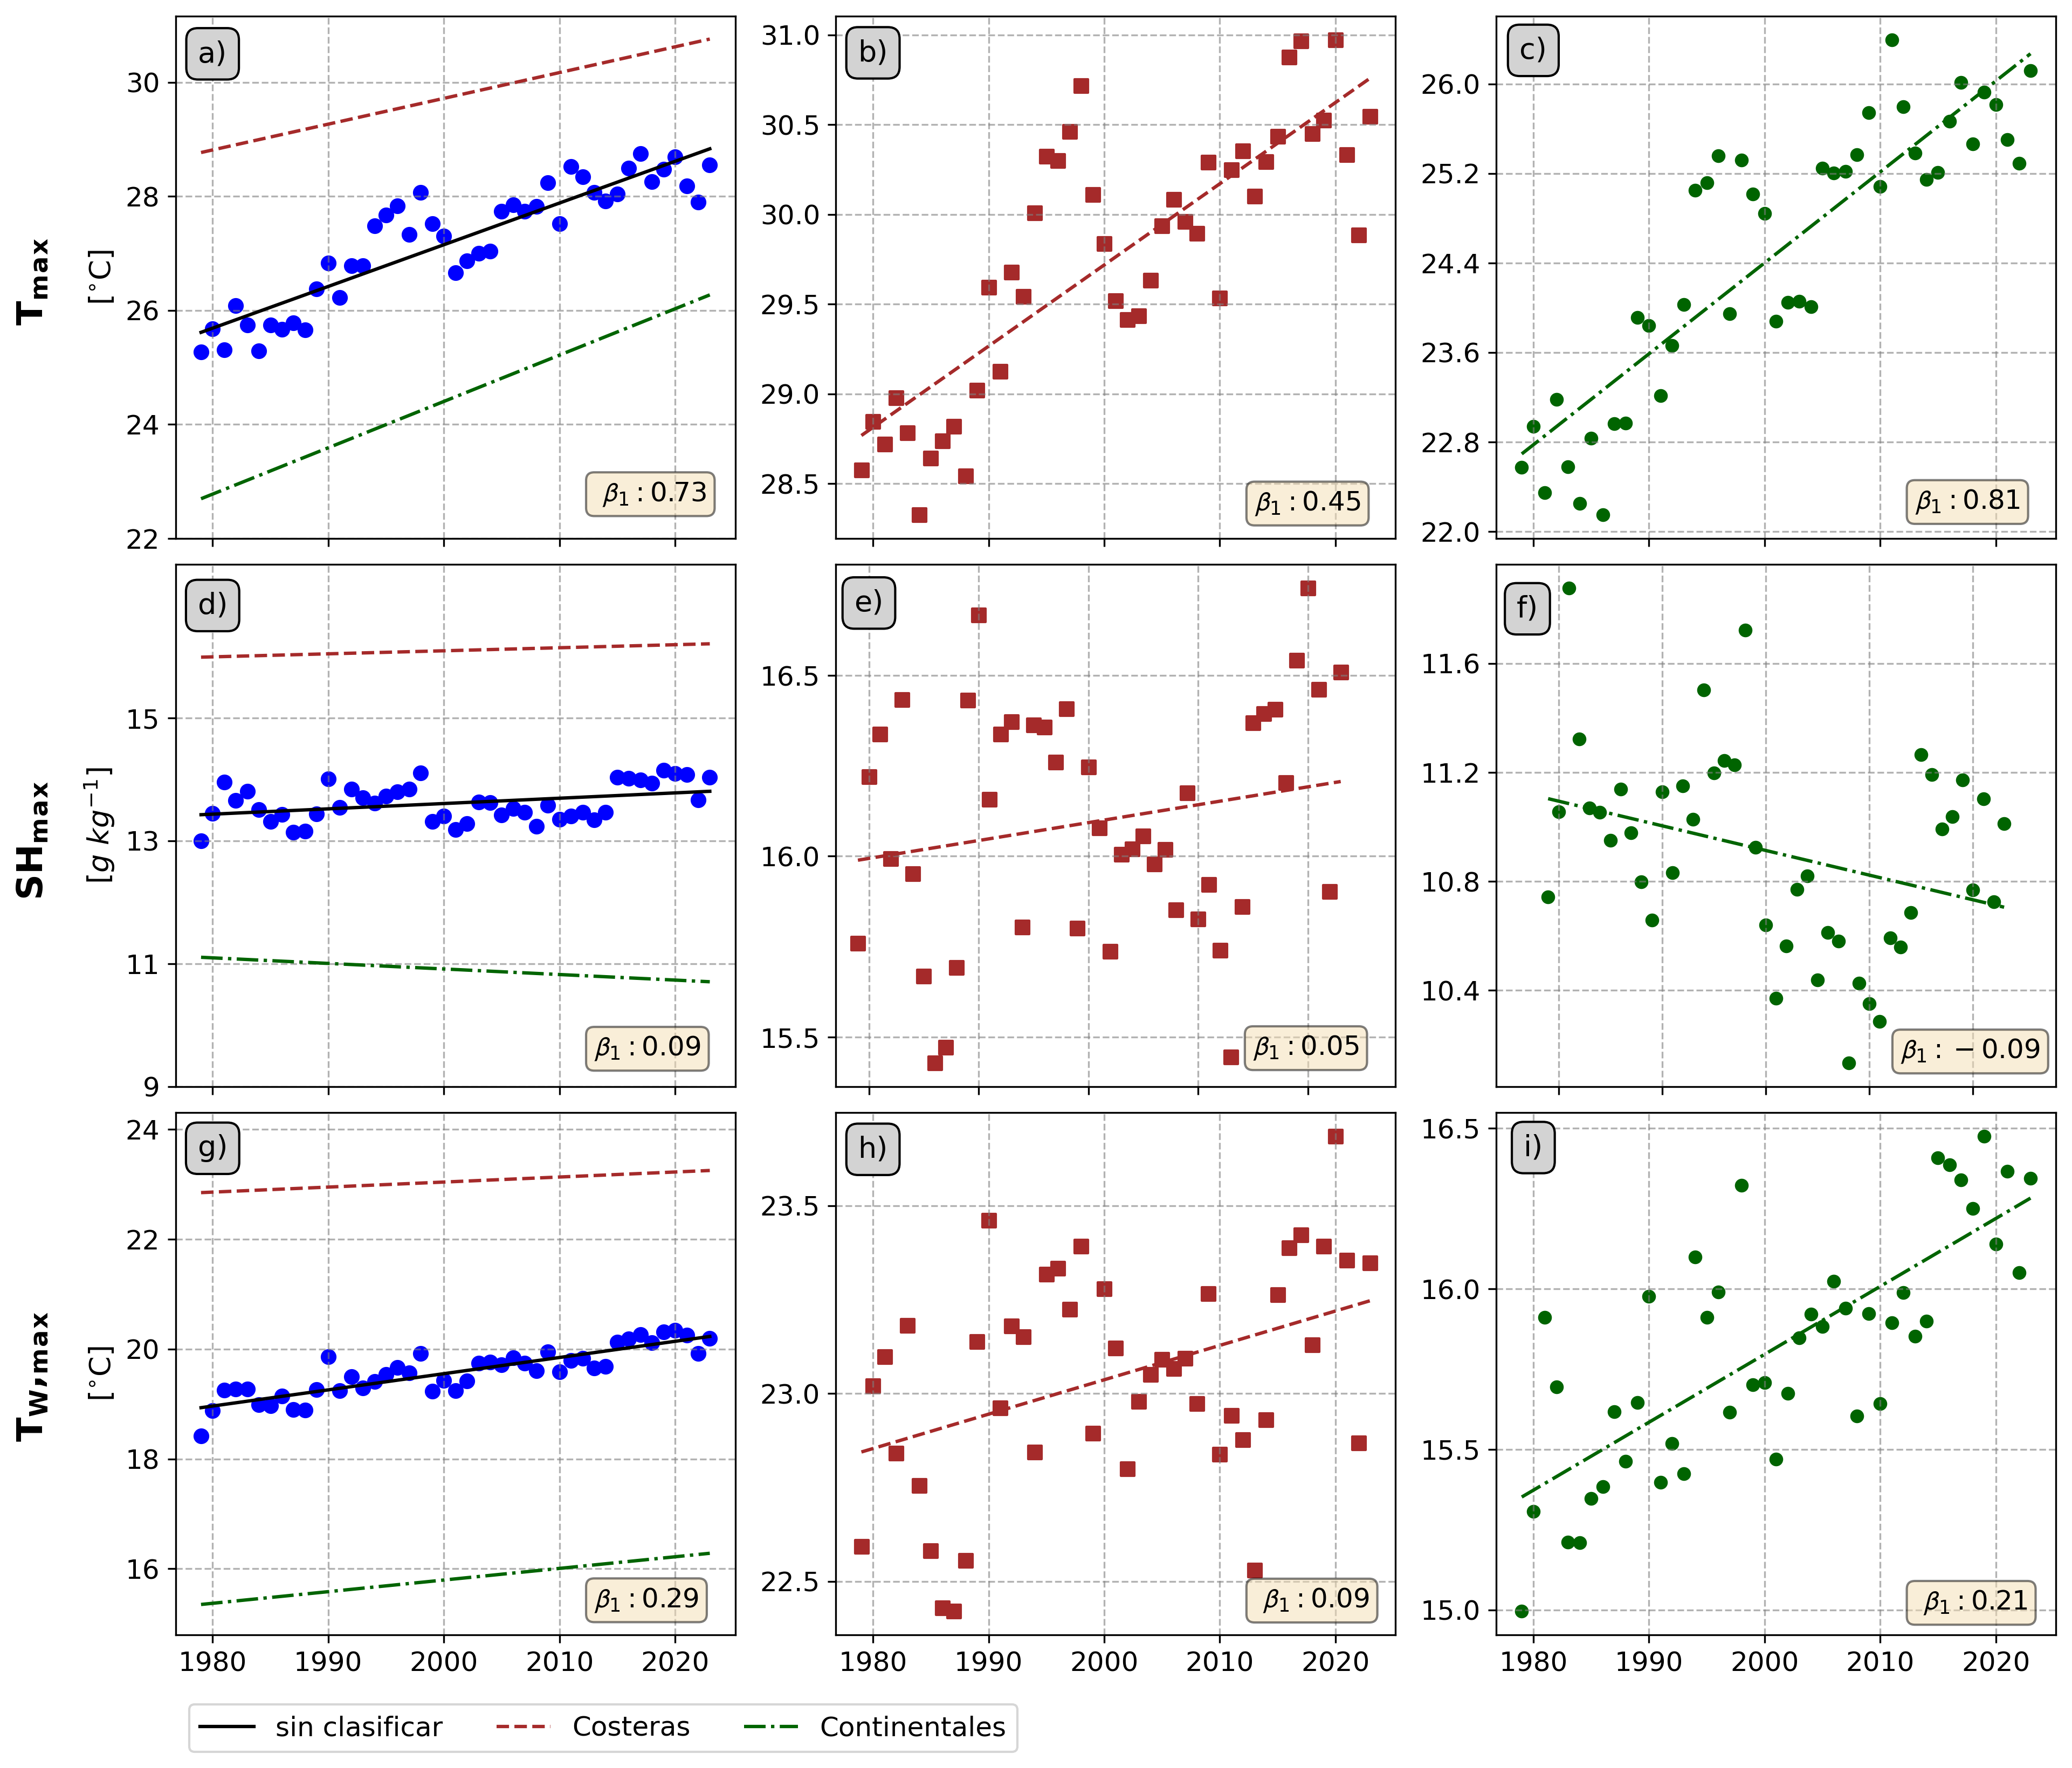

In [32]:
#Graficando las líneas de regresión
labels=["[$^{\circ}$C]","[$g$ $kg^{-1}$]","[$^{\circ}$C]"]
Temp=[modeloall1,tmax_cluster0,tmax_cluster1]
SH=[modeloall2,shmax_cluster0,shmax_cluster1]
TW=[modeloall3,twmax_cluster0,twmax_cluster1]
y=[p,TMAX_cluster0,TMAX_cluster1]
y1=[p1,SHMAX_cluster0,SHMAX_cluster1]
y2=[p2,TWMAX_cluster0,TWMAX_cluster1]
label=["C0","C1"]
color=["brown","darkgreen"]
linestyle=["--","-."]
title=["b)","c)"]
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
fig = plt.figure(figsize=(15, 13),dpi=300)
n=1
for i,ii in enumerate(Temp):
    plt.subplot(3,3,n)
    if n==1:
        plt.scatter(Tiempoall,y[i], color='blue')
       
        plt.plot(Tiempoall, ii.predict(X), color='black', label='All')
        plt.plot(Tiempoall, Temp[n].predict(X), color='brown', label='Costeras',linestyle="--")
        plt.plot(Tiempoall, Temp[n+1].predict(X), color='darkgreen', label='Continentales',linestyle="-.")
        #plt.xlabel('Década')
        plt.text(1980, 30.5, "a)", fontsize=13, color="black", ha="center", va="center",
                 bbox=dict(facecolor="lightgray", edgecolor="black", boxstyle="round",pad=0.4))
       
        plt.ylabel(labels[n-1],fontsize=13)
        #plt.title(r" $\mathbf{Temperatura}$ $\mathbf{máxima}$",fontsize=14)
        plt.text(1966, 26.5, r'$\mathbf{T}$$\mathbf{_m}$$\mathbf{_a}$$\mathbf{_x}$',fontsize=16, va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor')
        plt.xticks(color="white",fontsize=12)
        plt.yticks(np.arange(22,31,2),fontsize=12)
        #plt.title('Regresión lineal de la humedad específica por década')
        #textstr = '\n'.join((
   # r'$r^{2}$='%(np.around(ii.rsquared,2)),
   # r'$m=$'%(np.around(ii.params[1]*10,2))))
        plt.text(2013,22.65,(f" $\\mathbb{{\\beta}}_1{{:}} {(ii.params[1]*1000)/100:.2f}$"),fontsize=12,bbox=props)
       #$\\mathbb{{R}}^2{{:}} {(ii.rsquared*100)/100:.2f}$ \n
     
        plt.grid(linestyle="--", color="grey",alpha=0.6)
        n=n+1
    else:
        plt.subplot(3,3,n)
        
        if n==2:
            colors="brown"
            marker="s"
            ss=None
            #plt.yticks(np.arange(26,32,1))
            plt.text(1980, 30.9, "b)", fontsize=13, color="black", ha="center", va="center",
                 bbox=dict(facecolor="lightgray", edgecolor="black", boxstyle="round",pad=0.4))
        else:
            colors='darkgreen'
            marker="."
            ss=105
            plt.yticks(np.arange(22,27,0.8))
            plt.text(1980, 26.3, "c)", fontsize=13, color="black", ha="center", va="center",
                 bbox=dict(facecolor="lightgray", edgecolor="black", boxstyle="round",pad=0.4))
        plt.scatter(Tiempoall,y[i] , color=colors, marker=marker, label='Datos',s=ss)
        plt.plot(Tiempoall, ii.predict(X), color=colors,linestyle=linestyle[n-2], label=label[n-2])
        plt.xticks(color="white",fontsize=12)
        plt.yticks(fontsize=12)
        #plt.xlabel('Década')
        #plt.title('Regresión lineal de la humedad específica por década')
        #plt.legend()
        plt.grid(linestyle="--", color="grey",alpha=0.6)
        if n==3:
            plt.text(2013,22.2,(f"$\\mathbb{{\\beta}}_1{{:}} {(ii.params[1]*1000)/100:.2f}$"),fontsize=12,bbox=props)
        else:
            plt.text(2013,28.35,(f"$\\mathbb{{\\beta}}_1{{:}} {(ii.params[1]*1000)/100:.2f}$"),fontsize=12,bbox=props)
        n=n+1
Temp=[modeloall1,tmax_cluster0,tmax_cluster1]
SH=[modeloall2,shmax_cluster0,shmax_cluster1]
TW=[modeloall3,twmax_cluster0,twmax_cluster1]
y=[p,TMAX_cluster0,TMAX_cluster1]
y1=[p1,SHMAX_cluster0,SHMAX_cluster1]
y2=[p2,TWMAX_cluster0,TWMAX_cluster1]
label=["C0","C1"]
color=["black","brown"]
linestyle=["--","-."]
#fig = plt.figure(figsize=(14, 9),dpi=120)
n=4
p=0
for i,ii in enumerate(SH):
    plt.subplot(3,3,n)
    if n==4:
        plt.scatter(Tiempoall,y1[i]*1000 , color='blue', label='Datos')
        plt.xticks(color="white",fontsize=12)
        plt.yticks(np.arange(9,17,2),fontsize=12)
        plt.text(1966, 13, r'$\mathbf{SH}$$\mathbf{_m}$$\mathbf{_a}$$\mathbf{_x}$',fontsize=16, va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor')
        #plt.title(r"$\mathbf{Humedad}$ $\mathbf{específica}$ $\mathbf{máxima}$",fontsize=14)
        plt.text(1980, 16.83, "d)", fontsize=13, color="black", ha="center", va="center",
                 bbox=dict(facecolor="lightgray", edgecolor="black", boxstyle="round",pad=0.4))
    
        plt.plot(Tiempoall, ii.predict(X), color='black', label='All')
        plt.plot(Tiempoall, SH[1].predict(X), color='brown', label='C0',linestyle="--")
        plt.plot(Tiempoall, SH[2].predict(X), color='darkgreen', label='C1',linestyle="-.")
        plt.ylabel(labels[1],fontsize=13)
        plt.text(2013,9.5,(f"$\\mathbb{{\\beta}}_1{{:}} {(ii.params[1]*1000)/100:.2f}$"),fontsize=12,bbox=props)
        plt.ylim(9,17.5)
    
        #plt.title('Regresión lineal de la humedad específica por década')
        plt.grid(linestyle="--", color="grey",alpha=0.6)
        n=n+1
    else:
        plt.subplot(3,3,n)
        if n==5:
            colors="brown"
            marker="s"
            ss=None
            plt.yticks(np.arange(15,17,0.5))
            plt.text(1980, 16.7, "e)", fontsize=13, color="black", ha="center", va="center",
                 bbox=dict(facecolor="lightgray", edgecolor="black", boxstyle="round",pad=0.4))
            plt.xlim(1977,2028)
        elif n==6:
            colors='darkgreen'
            marker="."
            ss=105
            plt.xlim(1974,2028)
            plt.yticks(np.arange(10,12,0.4))
            plt.text(1977, 11.8, "f)", fontsize=13, color="black", ha="center", va="center",
                 bbox=dict(facecolor="lightgray", edgecolor="black", boxstyle="round",pad=0.4))
        plt.scatter(Tiempoall,y1[i]*1000, color=colors, marker=marker, label='Datos',s=ss)
        plt.plot(Tiempoall, ii.predict(X), color=colors,linestyle=linestyle[p-2], label=label[p-2])
        plt.xticks(color="white",fontsize=12)
        plt.yticks(fontsize=12)
     
        #plt.title('Regresión lineal de la humedad específica por década')
        if n==6:
            plt.text(2013,10.15,(f"$\\mathbb{{\\beta}}_1{{:}} {(ii.params[1]*1000)/100:.2f}$"),fontsize=12,bbox=props)
            
        else:
            plt.text(2015,15.45,(f"$\\mathbb{{\\beta}}_1{{:}} {(ii.params[1]*1000)/100:.2f}$"),fontsize=12,bbox=props)
        
        plt.grid(linestyle="--", color="grey",alpha=0.6)
        n=n+1
        p=p+1
Temp=[modeloall1,tmax_cluster0,tmax_cluster1]
SH=[modeloall2,shmax_cluster0,shmax_cluster1]
TW=[modeloall3,twmax_cluster0,twmax_cluster1]
y=[p,TMAX_cluster0,TMAX_cluster1]
y1=[p1,SHMAX_cluster0,SHMAX_cluster1]
y2=[p2,TWMAX_cluster0,TWMAX_cluster1]
label=["C0","C1"]
color=["black","brown"]
linestyle=["--","-."]
n=7
l=0
for i,ii in enumerate(TW):
    plt.subplot(3,3,n)
    if n==7:
        plt.scatter(Tiempoall,y2[i]-273.15 , color='blue')
        plt.plot(Tiempoall, ii.predict(X)-273.15, color='black', label='sin clasificar')
        plt.plot(Tiempoall, TW[1].predict(X)-273.15, color='brown', label='Costeras',linestyle="--")
        plt.plot(Tiempoall, TW[2].predict(X)-273.15, c='darkgreen', label='Continentales',linestyle="-.")
        plt.ylabel(labels[2],fontsize=13)
        plt.text(1980, 23.651, "g)", fontsize=13, color="black", ha="center", va="center",
                 bbox=dict(facecolor="lightgray", edgecolor="black", boxstyle="round",pad=0.4))
        #plt.title(r"$\mathbf{Temperatura}$ $\mathbf{de}$ $\mathbf{bulbo}$ $\mathbf{húmedo}$ $\mathbf{máxima}$",fontsize=14)
        plt.text(1966, 19.5, r'$\mathbf{T}$$\mathbf{_W}$$\mathbf{,}$$\mathbf{_m}$$\mathbf{_a}$$\mathbf{_x}$',fontsize=16, va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor')
        plt.text(2013,15.3,(f"$\\mathbb{{\\beta}}_1{{:}} {(ii.params[1]*1000)/100:.2f}$"),fontsize=12,bbox=props)
        #plt.title('Regresión lineal de la humedad específica por década')
        plt.xticks(fontsize=12)
        plt.legend(bbox_to_anchor=(0,-0.25), loc='lower left',ncol=3,fontsize=12)
       
        plt.yticks(fontsize=12)
        plt.grid(linestyle="--", color="grey",alpha=0.6)
        plt.ylim(14.8,24.3)

        n=n+1
    else:
        plt.subplot(3,3,n)
        if n==8:
            colors="brown"
            marker="s"
            ss=None
            plt.yticks(np.arange(22,24,0.5))
            plt.text(1980, 23.65, "h)", fontsize=13, color="black", ha="center", va="center",
                 bbox=dict(facecolor="lightgray", edgecolor="black", boxstyle="round",pad=0.4))
        elif n==9:
            colors='darkgreen'
            marker="."
            ss=105
            plt.yticks(np.arange(14,17,0.5))
            plt.text(1980, 16.44, "i)", fontsize=13, color="black", ha="center", va="center",
                 bbox=dict(facecolor="lightgray", edgecolor="black", boxstyle="round",pad=0.4))
        plt.scatter(Tiempoall,y2[i]-273.15 , color=colors,marker=marker,label='Datos',s=ss)
        plt.plot(Tiempoall, ii.predict(X)-273.15, color=colors,linestyle=linestyle[l-2], label=label[l-2])
        plt.xticks(fontsize=12)
        
        plt.yticks(fontsize=12)
        if n==9:
            plt.text(2013,15,(f" $\\mathbb{{\\beta}}_1{{:}} {(ii.params[1]*1000)/100:.2f}$"),fontsize=12,bbox=props)
        else:
            plt.text(2013,22.43,(f" $\\mathbb{{\\beta}}_1{{:}} {(ii.params[1]*1000)/100:.2f}$"),fontsize=12,bbox=props)
        #plt.title('Regresión lineal de la humedad específica por década')
        plt.grid(linestyle="--", color="grey",alpha=0.6)
        n=n+1
        l=l+1
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
plt.subplots_adjust(hspace=0.05,wspace=0.18)        
      
plt.savefig("regresion_Had.svg",bbox_inches="tight",dpi=300)
   